In [1]:
import os
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm, ticker
from astropy.io import fits
import astropy.io.ascii as astropy_ascii
from astropy.table import Table
from astropy import units as u
from astropy.coordinates import SkyCoord
from src.utils.constants import *
from src.utils.CosmoFunc import *

from scipy.stats import norm
from scipy.optimize import curve_fit

import emcee
import corner
import getdist
from getdist import plots, MCSamples

from matplotlib.ticker import FormatStrFormatter

# Plot configurations
GOLDEN_RATIO = 0.5*(1+np.sqrt(5))
FIGURE_HEIGHT = 5
FIGURE_WIDTH = FIGURE_HEIGHT*GOLDEN_RATIO
DEFAULT_FIGSIZE = (FIGURE_WIDTH, FIGURE_HEIGHT)

ROOT_PATH = '/Users/mrafifrbbn/Documents/thesis/thesis-research-2.0'

In [2]:
from dotenv import load_dotenv
load_dotenv()

USE_6dFGS_OFFSET = os.environ.get('USE_6dFGS_OFFSET')

USE_6dFGS_OFFSET

'false'

# A. Compare Old vs New Data

## A.1. 6dFGS

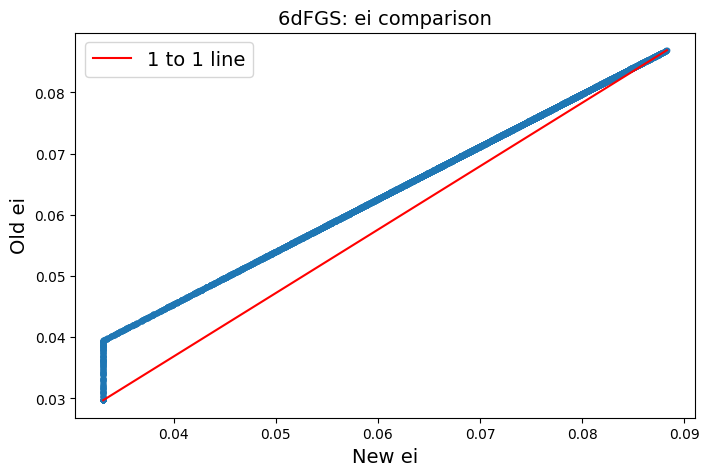

In [116]:
old_columns_dict = {
    '2MASS': 'tmass',
    'z_hel': 'zhelio',
    'z_cmb_group': 'z_dist_est'
}
df_old = pd.read_csv('archive/old_fp_data/6dfgs.csv').rename(old_columns_dict, axis=1)
df_new = pd.read_csv('data/foundation/fp_sample/6dfgs.csv')

df = df_new.merge(df_old, on='tmass', how='outer', indicator=True, suffixes=('_new', '_old'))

def plot_comparison(df, column, survey):
    fig, ax = plt.subplots(figsize=(8, 5))
    df_plot = df[(~df[f'{column}_new'].isna()) & (~df[f'{column}_old'].isna())]
    ax.scatter(df_plot[f'{column}_new'], df_plot[f'{column}_old'], s=10)
    ax.set_xlabel(f'New {column}', fontsize=14)
    ax.set_ylabel(f'Old {column}', fontsize=14)
    ax.set_title(f'{survey}: {column} comparison', fontsize=14)
    ax.plot([df_plot[f'{column}_new'].min(), df_plot[f'{column}_new'].max()], [df_plot[f'{column}_old'].min(), df_plot[f'{column}_old'].max()], c='r', label='1 to 1 line')
    ax.legend(fontsize=14)
    plt.show()
    
plot_comparison(df, 'ei', '6dFGS')

# df['delta_mag'] = df['j_m_ext_new'] - df['j_m_ext_old']
# df['delta_r'] = df['r_new'] - df['r_old']
# df['delta_s'] = df['s_new'] - df['s_old']
# df['delta_i'] = df['i_new'] - df['i_old']

# df[['tmass', '_6dFGS', '6dfgs', 'delta_r', 'delta_s', 'delta_i', 'delta_mag']].sort_values(by='delta_s').head(50)

## A.2. SDSS

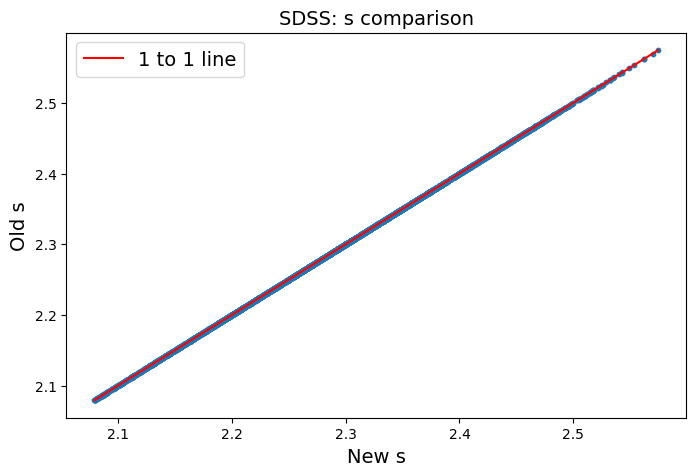

In [114]:
df_old = pd.read_csv('archive/old_fp_data/sdss.csv').rename(old_columns_dict, axis=1)
df_new = pd.read_csv('data/foundation/fp_sample/sdss.csv')

df = df_new.merge(df_old, on='tmass', how='outer', indicator=True, suffixes=('_new', '_old'))
    
plot_comparison(df, 's', 'SDSS')

## A.3. LAMOST

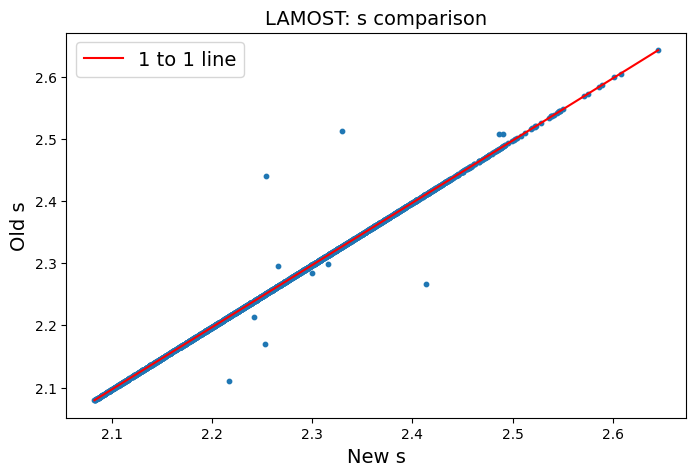

In [101]:
df_old = pd.read_csv('archive/old_fp_data/lamost.csv').rename(old_columns_dict, axis=1)
df_new = pd.read_csv('data/foundation/fp_sample/lamost.csv')

df = df_new.merge(df_old, on='tmass', how='outer', indicator=True, suffixes=('_new', '_old'))
    
plot_comparison(df, 's', 'LAMOST')

# 1. FITTING THE FP

In [147]:
INPUT_FILEPATH = {
    '6dFGS': 'data/foundation/fp_sample/6dfgs.csv',
    'SDSS': 'data/foundation/fp_sample/sdss.csv',
    'LAMOST': 'data/foundation/fp_sample/lamost.csv'
}

OUTLIER_REJECT_OUTPUT_FILEPATH = {
    '6dFGS': 'data/foundation/fp_sample/outlier_reject/6dfgs.csv',
    'SDSS': 'data/foundation/fp_sample/outlier_reject/sdss.csv',
    'LAMOST': 'data/foundation/fp_sample/outlier_reject/lamost.csv'
}

FP_FIT_FILEPATH = 'artifacts/fp_fit/fp_fits.csv'

MCMC_CHAIN_OUTPUT_FILEPATH = {
    '6dFGS': 'artifacts/fp_fit/6dfgs_chain.npy',
    'SDSS': 'artifacts/fp_fit/sdss_chain.npy',
    'LAMOST': 'artifacts/fp_fit/lamost_chain.npy'
}

LIKELIHOOD_DIST_IMG_FILEPATH = 'img/three_surveys_likelihood.png'

# The likelihood function for the Fundamental Plane
def FP_func(params, logdists, z_obs, r, s, i, err_r, err_s, err_i, Sn, dz, kr, Ar, smin, sumgals=True, chi_squared_only=False):

    # Trial FP parameters
    a, b, rmean, smean, imean, sigma1, sigma2, sigma3 = params 
    # The additional parameter assumed to be zero
    k = 0.0

    # These are the components of the eigenvectors and their magnitudes
    fac1, fac2, fac3, fac4 = k*a**2 + k*b**2 - a, k*a - 1.0 - b**2, b*(k+a), 1.0 - k*a
    norm1, norm2 = 1.0+a**2+b**2, 1.0+b**2+k**2*(a**2+b**2)-2.0*a*k
    # The components of the scatter matrix
    dsigma31, dsigma23 = sigma3**2-sigma1**2, sigma2**2-sigma3**3
    sigmar2 =  1.0/norm1*sigma1**2 +      b**2/norm2*sigma2**2 + fac1**2/(norm1*norm2)*sigma3**2
    sigmas2 = a**2/norm1*sigma1**2 + k**2*b**2/norm2*sigma2**2 + fac2**2/(norm1*norm2)*sigma3**2
    sigmai2 = b**2/norm1*sigma1**2 +   fac4**2/norm2*sigma2**2 + fac3**2/(norm1*norm2)*sigma3**2
    sigmars =  -a/norm1*sigma1**2 -   k*b**2/norm2*sigma2**2 + fac1*fac2/(norm1*norm2)*sigma3**2
    sigmari =  -b/norm1*sigma1**2 +   b*fac4/norm2*sigma2**2 + fac1*fac3/(norm1*norm2)*sigma3**2
    sigmasi = a*b/norm1*sigma1**2 - k*b*fac4/norm2*sigma2**2 + fac2*fac3/(norm1*norm2)*sigma3**2
    sigma_cov = np.array([[sigmar2, sigmars, sigmari], [sigmars, sigmas2, sigmasi], [sigmari, sigmasi, sigmai2]])

    # Compute the chi-squared and determinant (quickly!)
    # The component of the covariance matrix
    cov_r = err_r**2 + np.log10(1.0 + 300.0/(LIGHTSPEED*z_obs))**2 + sigmar2
    cov_s = err_s**2 + sigmas2
    cov_i = err_i**2 + sigmai2
    cov_ri = -1.0*err_r*err_i + sigmari

    # Minors of the covariance matrix
    A = cov_s*cov_i - sigmasi**2
    B = sigmasi*cov_ri - sigmars*cov_i
    C = sigmars*sigmasi - cov_s*cov_ri
    E = cov_r*cov_i - cov_ri**2
    F = sigmars*cov_ri - cov_r*sigmasi
    I = cov_r*cov_s - sigmars**2

    # Using the mean values rbar, sbar, ibar as the center
    sdiff, idiff = s - smean, i - imean
    rnew = r - np.tile(logdists, (len(r), 1)).T
    rdiff  = rnew - rmean

    # Determinant of the covariance matrix
    det = cov_r*A + sigmars*B + cov_ri*C
    log_det = np.log(det)/Sn

    # The chi-squared term of the likelihood function
    chi_squared = (A*rdiff**2 + E*sdiff**2 + I*idiff**2 + 2.0*rdiff*(B*sdiff + C*idiff) + 2.0*F*sdiff*idiff)/(det*Sn)

    # Compute the FN term for the Scut only
    delta = (A*F**2 + I*B**2 - 2.0*B*C*F)/det
    FN = np.log(0.5 * special.erfc(np.sqrt(E/(2.0*(det+delta)))*(smin-smean)))/Sn

    if chi_squared_only:
        return chi_squared
    elif sumgals:
        return 0.5 * np.sum(chi_squared + log_det + 2.0*FN)
    else:
        return 0.5 * (chi_squared + log_det)

# Calculates f_n (the integral over the censored 3D Gaussian of the Fundamental Plane) for a magnitude limit and velocity dispersion cut. 
def FN_func(FPparams, zobs, er, es, ei, lmin, lmax, smin):

    a, b, rmean, smean, imean, sigma1, sigma2, sigma3 = FPparams
    k = 0.0

    fac1, fac2, fac3, fac4 = k*a**2 + k*b**2 - a, k*a - 1.0 - b**2, b*(k+a), 1.0 - k*a
    norm1, norm2 = 1.0+a**2+b**2, 1.0+b**2+k**2*(a**2+b**2)-2.0*a*k
    dsigma31, dsigma23 = sigma3**2-sigma1**2, sigma2**2-sigma3**3
    sigmar2 =  1.0/norm1*sigma1**2 +      b**2/norm2*sigma2**2 + fac1**2/(norm1*norm2)*sigma3**2
    sigmas2 = a**2/norm1*sigma1**2 + k**2*b**2/norm2*sigma2**2 + fac2**2/(norm1*norm2)*sigma3**2
    sigmai2 = b**2/norm1*sigma1**2 +   fac4**2/norm2*sigma2**2 + fac3**2/(norm1*norm2)*sigma3**2
    sigmars =  -a/norm1*sigma1**2 -   k*b**2/norm2*sigma2**2 + fac1*fac2/(norm1*norm2)*sigma3**2
    sigmari =  -b/norm1*sigma1**2 +   b*fac4/norm2*sigma2**2 + fac1*fac3/(norm1*norm2)*sigma3**2
    sigmasi = a*b/norm1*sigma1**2 - k*b*fac4/norm2*sigma2**2 + fac2*fac3/(norm1*norm2)*sigma3**2

    err_r = er**2 + np.log10(1.0 + 300.0/(LIGHTSPEED*zobs))**2 + sigmar2
    err_s = es**2 + sigmas2
    err_i = ei**2 + sigmai2
    cov_ri = -1.0*er*ei + sigmari

    A = err_s*err_i - sigmasi**2
    B = sigmasi*cov_ri - sigmars*err_i
    C = sigmars*sigmasi - err_s*cov_ri
    E = err_r*err_i - cov_ri**2
    F = sigmars*cov_ri - err_r*sigmasi
    I = err_r*err_s - sigmars**2

    # Inverse of the determinant!!
    det = 1.0/(err_r*A + sigmars*B + cov_ri*C)

    # Compute all the G, H and R terms
    G = np.sqrt(E)/(2*F-B)*(C*(2*F+B) - A*F - 2.0*B*I)
    delta = (I*B**2 + A*F**2 - 2.0*B*C*F)*det**2
    Edet = E*det
    Gdet = (G*det)**2
    Rmin = (lmin - rmean - imean/2.0)*np.sqrt(2.0*delta/det)/(2.0*F-B)
    Rmax = (lmax - rmean - imean/2.0)*np.sqrt(2.0*delta/det)/(2.0*F-B)

    G0 = -np.sqrt(2.0/(1.0+Gdet))*Rmax
    G2 = -np.sqrt(2.0/(1.0+Gdet))*Rmin
    G1 = -np.sqrt(Edet/(1.0+delta))*(smin - smean)

    H = np.sqrt(1.0+Gdet+delta)
    H0 = G*det*np.sqrt(delta) - np.sqrt(Edet/2.0)*(1.0+Gdet)*(smin - smean)/Rmax
    H2 = G*det*np.sqrt(delta) - np.sqrt(Edet/2.0)*(1.0+Gdet)*(smin - smean)/Rmin
    H1 = G*det*np.sqrt(delta) - np.sqrt(2.0/Edet)*(1.0+delta)*Rmax/(smin - smean)
    H3 = G*det*np.sqrt(delta) - np.sqrt(2.0/Edet)*(1.0+delta)*Rmin/(smin - smean)

    FN = special.owens_t(G0, H0/H)+special.owens_t(G1, H1/H)-special.owens_t(G2, H2/H)-special.owens_t(G1, H3/H)
    FN += 1.0/(2.0*np.pi)*(np.arctan2(H2,H)+np.arctan2(H3,H)-np.arctan2(H0,H)-np.arctan2(H1,H))
    FN += 1.0/4.0*(special.erf(G0/np.sqrt(2.0))-special.erf(G2/np.sqrt(2.0)))

    # This can go less than zero for very large distances if there are rounding errors, so set a floor
    # This shouldn't affect the measured logdistance ratios as these distances were already very low probability!
    index = np.where(FN < 1.0e-15)
    FN[index] = 1.0e-15

    return np.log(FN)

def fit_FP():
    # Set global random seed
    np.random.seed(42)
    
    # List to store FP parameters
    FP_params = []
    
    for survey in SURVEY_LIST:
        print(f"{'=' * 10} Fitting {survey} Fundamental Plane {'=' * 10}")
        df = pd.read_csv(INPUT_FILEPATH[survey])

        # p-value upper limit, reject galaxies with p-value lower than this limit
        pvals_cut = 0.01

        # The magnitude limit and velocity dispersion limits (very important!), and Omega_m (less important)
        omega_m = 0.3121
        smin = np.log10(112)# + 0.019
        mag_low = 8.0
        mag_high = 13.65

        # Get some redshift-distance lookup tables
        red_spline, lumred_spline, dist_spline, lumdist_spline, ez_spline = rz_table()
        # The comoving distance to each galaxy using group redshift as distance indicator
        dz = sp.interpolate.splev(df["z_dist_est"].to_numpy(), dist_spline, der=0) 

        # Compute the S_n weights using the V_max method.
        zmin = 3000.0 / LIGHTSPEED
        zmax = 16120.0 / LIGHTSPEED
        # (1+z) factor because we use luminosity distance
        Vmin = (1.0 + zmin)**3 * sp.interpolate.splev(zmin, dist_spline)**3
        Vmax = (1.0 + zmax)**3 * sp.interpolate.splev(zmax, dist_spline)**3
        # Maximum (luminosity) distance the galaxy can be observed given mag_high (survey limiting magnitude)
        Dlim = 10.0**((mag_high - (df["j_m_ext"] - df['extinction_j']) + 5.0 * np.log10(dz) + 5.0 * np.log10(1.0 + df["zhelio"])) / 5.0)    
        # Find the corresponding maximum redshift
        zlim = sp.interpolate.splev(Dlim, lumred_spline)
        Sn = np.where(zlim >= zmax, 1.0, np.where(zlim <= zmin, 0.0, (Dlim**3 - Vmin)/(Vmax - Vmin)))

        # Fitting the FP iteratively by rejecting galaxies with high chi-square (low p-values) in each iteration
        data_fit = df
        badcount = len(df)
        print(len(data_fit), badcount)
        is_converged = False
        i = 1
        
        while not is_converged:
            dz_cluster_fit = sp.interpolate.splev(data_fit["z_dist_est"].to_numpy(), dist_spline)
            Dlim = 10.0**((mag_high - (data_fit["j_m_ext"]-data_fit['extinction_j']).to_numpy() + 5.0 * np.log10(dz_cluster_fit) + 5.0*np.log10(1.0 + data_fit["zhelio"]))/5.0)
            zlim = sp.interpolate.splev(Dlim, lumred_spline)

            Snfit = np.where(zlim >= zmax, 1.0, np.where(zlim <= zmin, 0.0, (Dlim**3 - Vmin)/(Vmax - Vmin)))

            # The range of the FP parameters' values
            avals, bvals = (1.3, 1.8), (-1.0, -0.5)
            rvals, svals, ivals = (-0.5, 0.5), (2.0, 2.5), (3.0, 3.5)
            s1vals, s2vals, s3vals = (0., 0.3), (0.1, 0.5), (0.1, 0.3)

            # Fit the FP parameters
            FPparams = sp.optimize.differential_evolution(FP_func, bounds=(avals, bvals, rvals, svals, ivals, s1vals, s2vals, s3vals), 
                args=(0.0, data_fit["z_cmb"].to_numpy(), data_fit["r"].to_numpy(), data_fit["s"].to_numpy(), data_fit["i"].to_numpy(), data_fit["er"].to_numpy(), data_fit["es"].to_numpy(), data_fit["ei"].to_numpy(), Snfit, dz, data_fit["kcor_j"].to_numpy(), data_fit["extinction_j"].to_numpy(), smin), seed=42, maxiter=10000, tol=1.0e-6)
            # Calculate the chi-squared 
            chi_squared = Sn*FP_func(FPparams.x, 0.0, df["z_cmb"].to_numpy(), df["r"].to_numpy(), df["s"].to_numpy(), df["i"].to_numpy(), df["er"].to_numpy(), df["es"].to_numpy(), df["ei"].to_numpy(), Sn, dz, df["kcor_j"].to_numpy(), df["extinction_j"].to_numpy(), smin, sumgals=False, chi_squared_only=True)[0]

            # Calculate the p-value (x,dof)
            pvals = sp.stats.chi2.sf(chi_squared, np.sum(chi_squared)/(len(df) - 8.0))
            # Reject galaxies with p-values < pvals_cut
            data_fit = df.drop(df[pvals < pvals_cut].index).reset_index(drop=True)
            # Count the number of rejected galaxies
            badcountnew = len(np.where(pvals < pvals_cut)[0])
            # Converged if the number of rejected galaxies in this iteration is the same as previous iteration
            is_converged = True if badcount == badcountnew else False

            # Print verbose
            print(f"{'-' * 10} Iteration {i} {'-' * 10}")
            print(FPparams.x.tolist())
            a_fit, b_fit, rmean_fit, smean_fit, imean_fit, s1_fit, s2_fit, s3_fit = FPparams.x
            print(f"a = {round(a_fit, 5)}")
            print(f"b = {round(b_fit, 5)}")
            print(f"rmean = {round(rmean_fit, 5)}")
            print(f"smean = {round(smean_fit, 5)}")
            print(f"imean = {round(imean_fit, 5)}")
            print(f"s1 = {round(s1_fit, 5)}")
            print(f"s2 = {round(s2_fit, 5)}")
            print(f"s3 = {round(s3_fit, 5)}")
            print(f"Data count = {len(data_fit)}")
            print(f"Chi-squared = {sp.stats.chi2.isf(0.01, np.sum(chi_squared)/(len(df) - 8.0))}")
            print(f"Outlier count = {badcount}")
            print(f"New outlier count = {badcountnew}")
            print(f"Converged = {is_converged}")
            
            # Set the new count of rejected galaxies
            badcount = badcountnew
            i += 1

        # Store the FP parameters
        FP_params.append(FPparams.x)
        
        # Save the cleaned sample
        df = data_fit
        df.to_csv(OUTLIER_REJECT_OUTPUT_FILEPATH[survey], index=False)
        print('\n')
        
    # Convert the FP parameters to dataframe and save to artifacts folder
    FP_params = np.array(FP_params)
    FP_columns = ['a', 'b', 'rmean', 'smean', 'imean', 's1', 's2', 's3']
    pd.DataFrame(FP_params, columns=FP_columns, index=SURVEY_LIST).to_csv(FP_FIT_FILEPATH)

def sample_likelihood():
    # The log-prior function for the FP parameters
    def log_prior(theta, param_boundaries):
        a, b, rmean, smean, imean, sig1, sig2, sig3 = theta
        a_bound, b_bound, rmean_bound, smean_bound, imean_bound, s1_bound, s2_bound, s3_bound = param_boundaries
        if a_bound[0] < a < a_bound[1] and b_bound[0] < b < b_bound[1] and rmean_bound[0] < rmean < rmean_bound[1] and smean_bound[0] < smean < smean_bound[1] and imean_bound[0] < imean < imean_bound[1] and s1_bound[0] < sig1 < s1_bound[1] and s2_bound[0] < sig2 < s2_bound[1] and s3_bound[0] < sig3 < s3_bound[1]:
            return 0.0
        else:
            return -np.inf

    # Calculate log-posterior distribution
    def log_probability(theta, param_boundaries, logdists, z_obs, r, s, i, err_r, err_s, err_i, Sn, dz, kr, Ar, smin, sumgals=True, chi_squared_only=False):
        lp = log_prior(theta, param_boundaries)
        if not np.isfinite(lp):
            return -np.inf
        else:
            return lp - FP_func(theta, 0., z, r, s, i, dr, ds, di, Sn, dz, 0., 0., smin, sumgals=True, chi_squared_only=False)
    
    for survey in SURVEY_LIST:
        # Load the outlier-rejected data
        df = pd.read_csv(OUTLIER_REJECT_OUTPUT_FILEPATH[survey])

        z = df['z_dist_est'].to_numpy()
        r = df['r'].to_numpy()
        s = df['s'].to_numpy()
        i = df['i'].to_numpy()
        dr = df['er'].to_numpy()
        ds = df['es'].to_numpy()
        di = df['ei'].to_numpy()
        mag_j = df['j_m_ext'].to_numpy()
        A_j = df['extinction_j'].to_numpy()

        # The magnitude limit and velocity dispersion limits (very important!), and Omega_m (less important)
        omega_m = 0.3121
        smin = np.log10(112)# + 0.019
        mag_low = 8.0
        mag_high = 13.65

        # Get some redshift-distance lookup tables
        red_spline, lumred_spline, dist_spline, lumdist_spline, ez_spline = rz_table()
        # The comoving distance to each galaxy using group redshift as distance indicator
        dz = sp.interpolate.splev(df["z_dist_est"].to_numpy(), dist_spline, der=0) 

        # Compute the S_n weights using the V_max method.
        zmin = 3000.0 / LIGHTSPEED
        zmax = 16120. / LIGHTSPEED
        # (1+z) factor because we use luminosity distance
        Vmin = (1.0 + zmin)**3 * sp.interpolate.splev(zmin, dist_spline)**3
        Vmax = (1.0 + zmax)**3 * sp.interpolate.splev(zmax, dist_spline)**3
        # Maximum (luminosity) distance the galaxy can be observed given mag_high (survey limiting magnitude)
        Dlim = 10.0**((mag_high - (df["j_m_ext"] - df['extinction_j']) + 5.0 * np.log10(dz) + 5.0 * np.log10(1.0 + df["zhelio"])) / 5.0)    
        # Find the corresponding maximum redshift
        zlim = sp.interpolate.splev(Dlim, lumred_spline)
        Sn = np.where(zlim >= zmax, 1.0, np.where(zlim <= zmin, 0.0, (Dlim**3 - Vmin)/(Vmax - Vmin)))

        # Load the best-fit parameters
        FP_params = pd.read_csv(FP_FIT_FILEPATH, index_col=0).loc[survey].to_numpy()

        # Specify the initial guess, the number of walkers, and dimensions
        pos = FP_params + 1e-2 * np.random.randn(16, 8)
        nwalkers, ndim = pos.shape

        # Flat prior boundaries (same order as FP_params)
        param_boundaries = [(1.3, 1.8), (-1.0, -0.5), (-0.5, 0.5), (1.8, 2.5), (2.8, 3.5), (0.0, 0.3), (0.1, 0.5), (0.1, 0.3)]

        # Run the MCMC
        sampler = emcee.EnsembleSampler(
            nwalkers, ndim, log_probability, args=(param_boundaries, 0., z, r, s, i, dr, ds, di, Sn, dz, 0., 0., smin, True, False)
        )
        sampler.run_mcmc(pos, 10000, progress=True, skip_initial_state_check=True)

        # Flatten the chain and save as numpy array
        flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
        np.save(MCMC_CHAIN_OUTPUT_FILEPATH[survey], flat_samples)
        
def generate_corner_plot():
    # Set border thickness
    mpl.rcParams['axes.linewidth'] = 2.0

    # 6dFGS data (mocks and previous values)
    samples_6df = np.load(MCMC_CHAIN_OUTPUT_FILEPATH['6dFGS'])
    prev_vals_6df = pd.read_csv(FP_FIT_FILEPATH, index_col=0).loc['6dFGS'].to_numpy()

    # SDSS data (mocks and previous values)
    samples_sdss = np.load(MCMC_CHAIN_OUTPUT_FILEPATH['SDSS'])
    prev_vals_sdss = pd.read_csv(FP_FIT_FILEPATH, index_col=0).loc['SDSS'].to_numpy()

    # LAMOST data (mocks and previous values)
    samples_lamost = np.load(MCMC_CHAIN_OUTPUT_FILEPATH['LAMOST'])
    prev_vals_lamost = pd.read_csv(FP_FIT_FILEPATH, index_col=0).loc['LAMOST'].to_numpy()

    # parameter names
    names = [r'$a$', r'$b$', r'$\bar{r}$', r'$\bar{s}$', r'$\bar{\imath}$', r'$\sigma_1$', r'$\sigma_2$', r'$\sigma_3$']

    samples1 = getdist.MCSamples(samples=samples_6df, names=names, label='6dFGS')
    samples2 = getdist.MCSamples(samples=samples_sdss, names=names, label='SDSS')
    samples3 = getdist.MCSamples(samples=samples_lamost, names=names, label='LAMOST')

    # Triangle plot
    g = getdist.plots.get_subplot_plotter()
    g.settings.legend_fontsize = 25
    g.settings.axes_fontsize = 15
    g.settings.axes_labelsize = 20
    g.triangle_plot([samples1, samples2, samples3], filled=True)

    ndim = 8
    for i in range(ndim):    
        for j in range(ndim):
            if j<=i:
                ax = g.subplots[i,j]
                ax.axvline(prev_vals_6df[j], color='grey', ls='--', alpha=0.5)
                ax.axvline(prev_vals_sdss[j], color='red', ls='--', alpha=0.5)
                ax.axvline(prev_vals_lamost[j], color='blue', ls='--', alpha=0.5)

                if i != j:
                    ax.axhline(prev_vals_6df[i], color='grey', ls='--', alpha=0.5)
                    ax.axhline(prev_vals_sdss[i], color='red', ls='--', alpha=0.5)
                    ax.axhline(prev_vals_lamost[i], color='blue', ls='--', alpha=0.5)

    g.export(LIKELIHOOD_DIST_IMG_FILEPATH, dpi=300)
    
def main():
#     fit_FP()
    
#     sample_likelihood()
    
#     generate_corner_plot()
    return

if __name__ == '__main__':
    main()

# 2. Experiment: MCMC sampling of the likelihood

In [44]:
MCMC_CHAIN_OUTPUT_FILEPATH = {
    '6dFGS': 'artifacts/fp_fit/6dfgs_chain.npy',
    'SDSS': 'artifacts/fp_fit/sdss_chain.npy',
    'LAMOST': 'artifacts/fp_fit/lamost_chain.npy'
}

# The log-prior function for the FP parameters
def log_prior(theta, param_boundaries):
    a, b, rmean, smean, imean, sig1, sig2, sig3 = theta
    a_bound, b_bound, rmean_bound, smean_bound, imean_bound, s1_bound, s2_bound, s3_bound = param_boundaries
    if a_bound[0] < a < a_bound[1] and b_bound[0] < b < b_bound[1] and rmean_bound[0] < rmean < rmean_bound[1] and smean_bound[0] < smean < smean_bound[1] and imean_bound[0] < imean < imean_bound[1] and s1_bound[0] < sig1 < s1_bound[1] and s2_bound[0] < sig2 < s2_bound[1] and s3_bound[0] < sig3 < s3_bound[1]:
        return 0.0
    else:
        return -np.inf
    
# Calculate log-posterior distribution
def log_probability(theta, param_boundaries, logdists, z_obs, r, s, i, err_r, err_s, err_i, Sn, dz, kr, Ar, smin, sumgals=True, chi_squared_only=False):
    lp = log_prior(theta, param_boundaries)
    if not np.isfinite(lp):
        return -np.inf
    else:
        return lp - FP_func(theta, 0., z, r, s, i, dr, ds, di, Sn, dz, 0., 0., smin, sumgals=True, chi_squared_only=False)

if __name__ == "__main__":
    
    for survey in SURVEY_LIST:
        # Load the outlier-rejected data
        df = pd.read_csv(OUTLIER_REJECT_OUTPUT_FILEPATH[survey])

        z = df['z_dist_est'].to_numpy()
        r = df['r'].to_numpy()
        s = df['s'].to_numpy()
        i = df['i'].to_numpy()
        dr = df['er'].to_numpy()
        ds = df['es'].to_numpy()
        di = df['ei'].to_numpy()
        mag_j = df['j_m_ext'].to_numpy()
        A_j = df['extinction_j'].to_numpy()

        # The magnitude limit and velocity dispersion limits (very important!), and Omega_m (less important)
        omega_m = 0.3121
        smin = np.log10(112)# + 0.019
        mag_low = 8.0
        mag_high = 13.65

        # Get some redshift-distance lookup tables
        red_spline, lumred_spline, dist_spline, lumdist_spline, ez_spline = rz_table()
        # The comoving distance to each galaxy using group redshift as distance indicator
        dz = sp.interpolate.splev(df["z_dist_est"].to_numpy(), dist_spline, der=0) 

        # Compute the S_n weights using the V_max method.
        zmin = 3000.0 / LIGHTSPEED
        zmax = 16120. / LIGHTSPEED
        # (1+z) factor because we use luminosity distance
        Vmin = (1.0 + zmin)**3 * sp.interpolate.splev(zmin, dist_spline)**3
        Vmax = (1.0 + zmax)**3 * sp.interpolate.splev(zmax, dist_spline)**3
        # Maximum (luminosity) distance the galaxy can be observed given mag_high (survey limiting magnitude)
        Dlim = 10.0**((mag_high - (df["j_m_ext"] - df['extinction_j']) + 5.0 * np.log10(dz) + 5.0 * np.log10(1.0 + df["zhelio"])) / 5.0)    
        # Find the corresponding maximum redshift
        zlim = sp.interpolate.splev(Dlim, lumred_spline)
        Sn = np.where(zlim >= zmax, 1.0, np.where(zlim <= zmin, 0.0, (Dlim**3 - Vmin)/(Vmax - Vmin)))

        # Load the best-fit parameters
        FP_params = pd.read_csv(FP_FIT_FILEPATH, index_col=0).loc[survey].to_numpy()

        # Specify the initial guess, the number of walkers, and dimensions
        pos = FP_params + 1e-2 * np.random.randn(16, 8)
        nwalkers, ndim = pos.shape

        # Flat prior boundaries (same order as FP_params)
        param_boundaries = [(1.3, 1.8), (-1.0, -0.5), (-0.5, 0.5), (1.8, 2.5), (2.8, 3.5), (0.0, 0.3), (0.1, 0.5), (0.1, 0.3)]

        # Run the MCMC
        sampler = emcee.EnsembleSampler(
            nwalkers, ndim, log_probability, args=(param_boundaries, 0., z, r, s, i, dr, ds, di, Sn, dz, 0., 0., smin, True, False)
        )
        sampler.run_mcmc(pos, 10000, progress=True, skip_initial_state_check=True)

        # Flatten the chain and save as numpy array
        flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
        np.save(MCMC_CHAIN_OUTPUT_FILEPATH[survey], flat_samples)

100%|████████████████████████████████████| 10000/10000 [00:18<00:00, 527.31it/s]


(10560, 8)


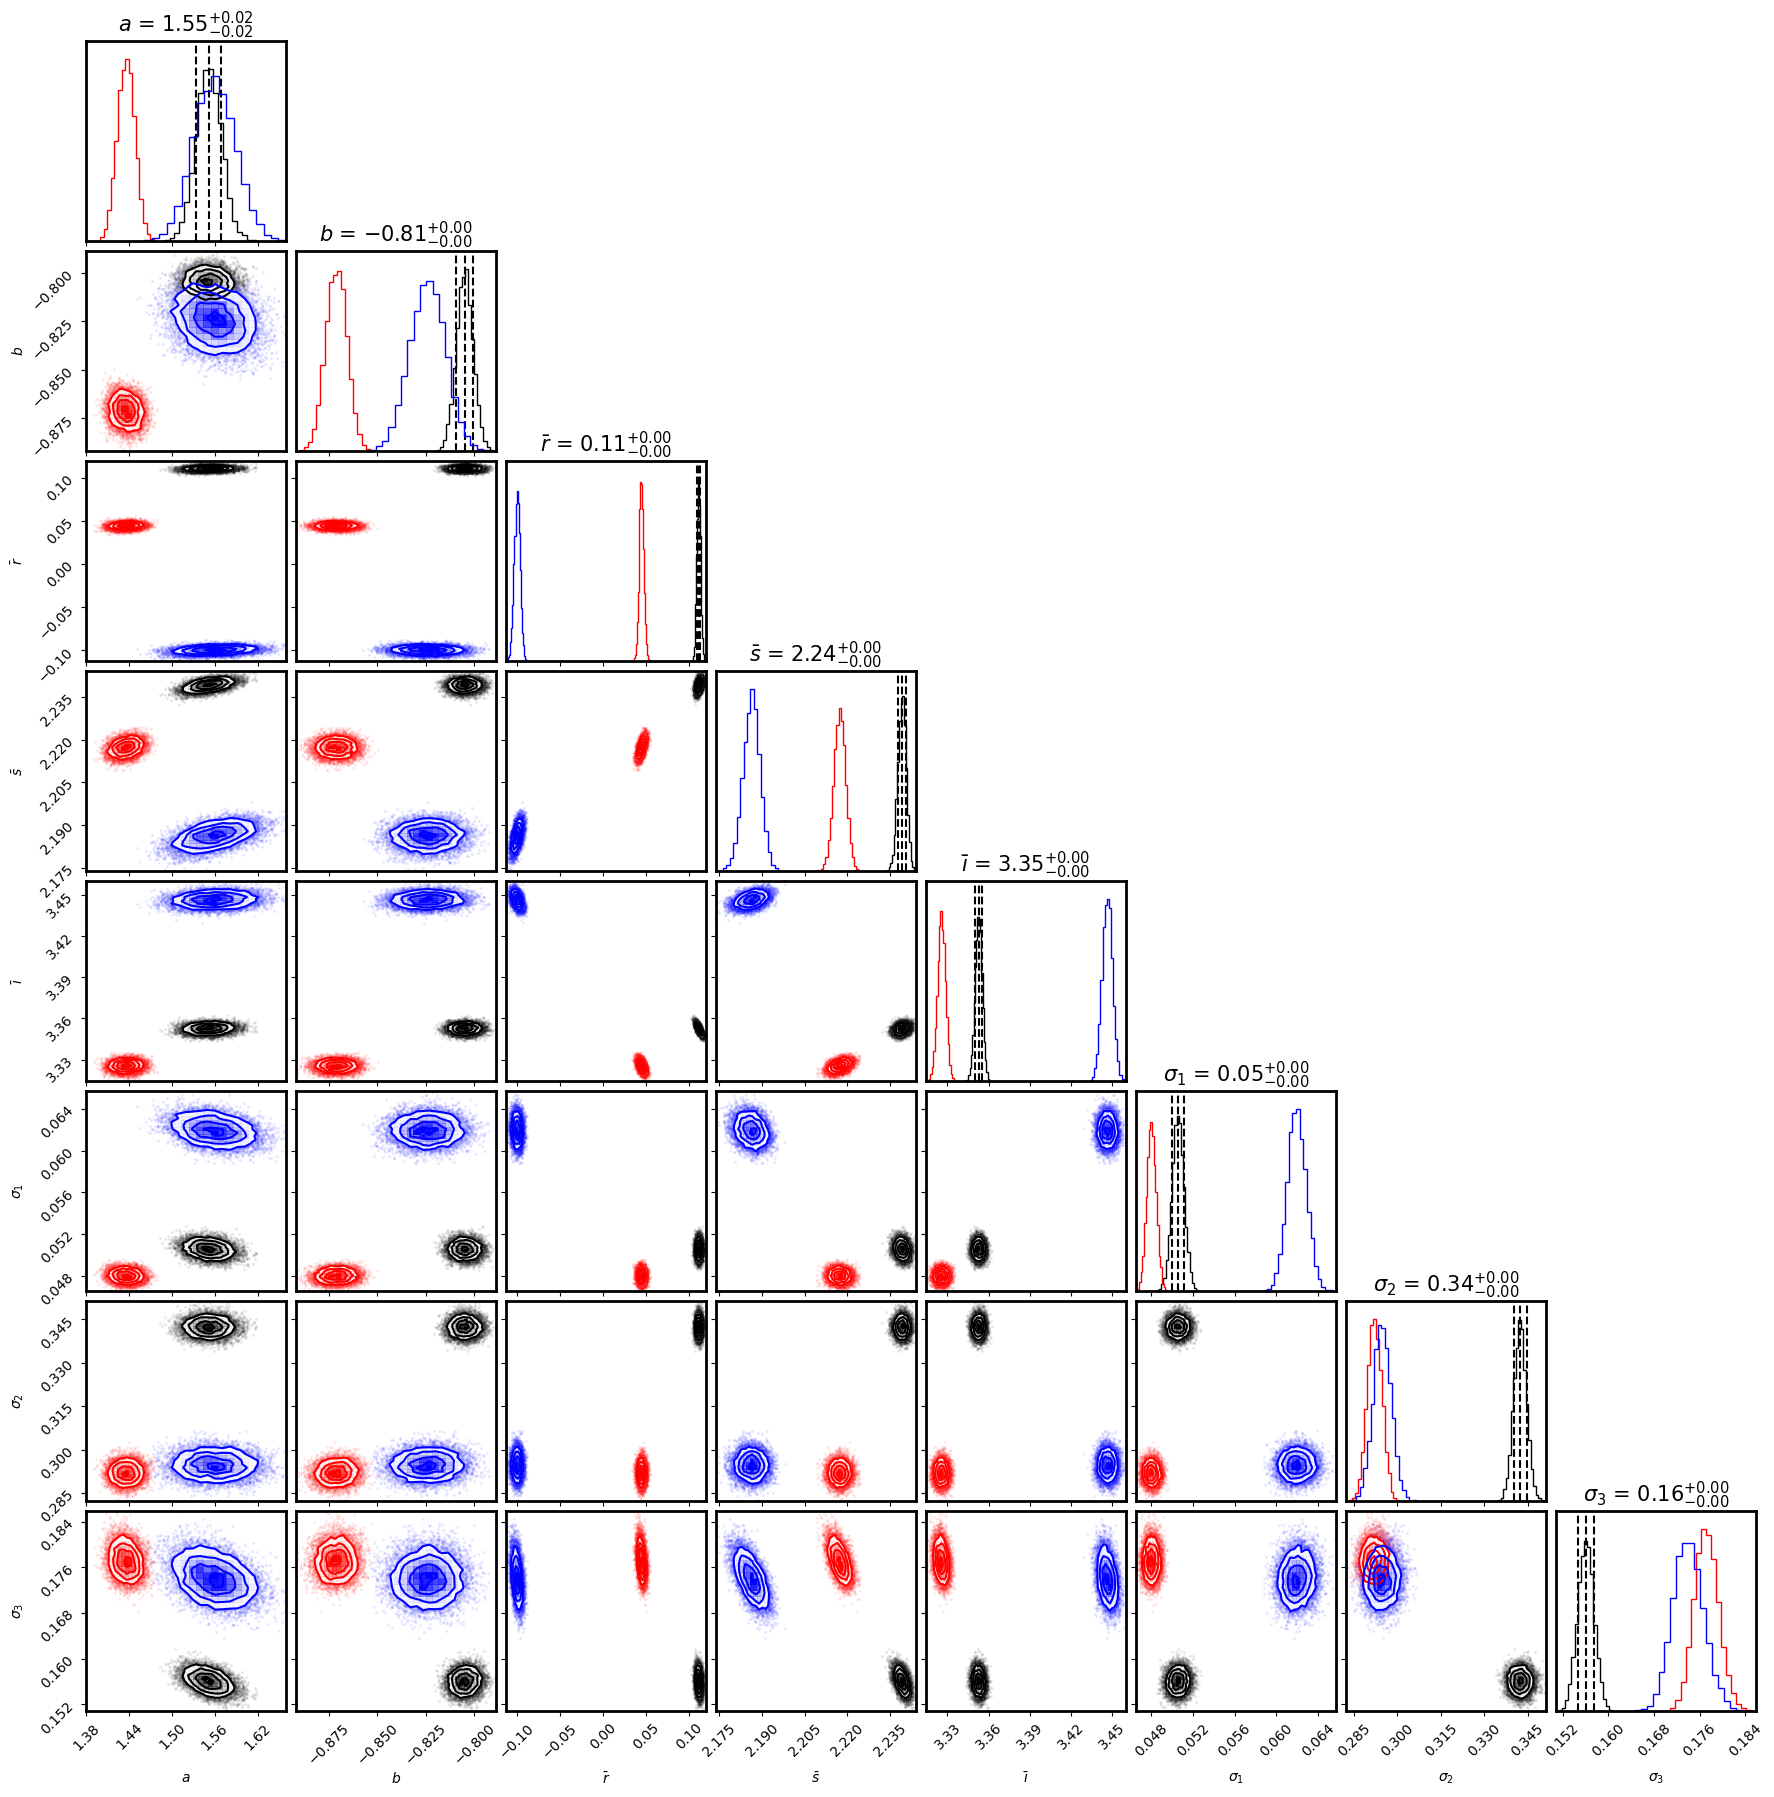

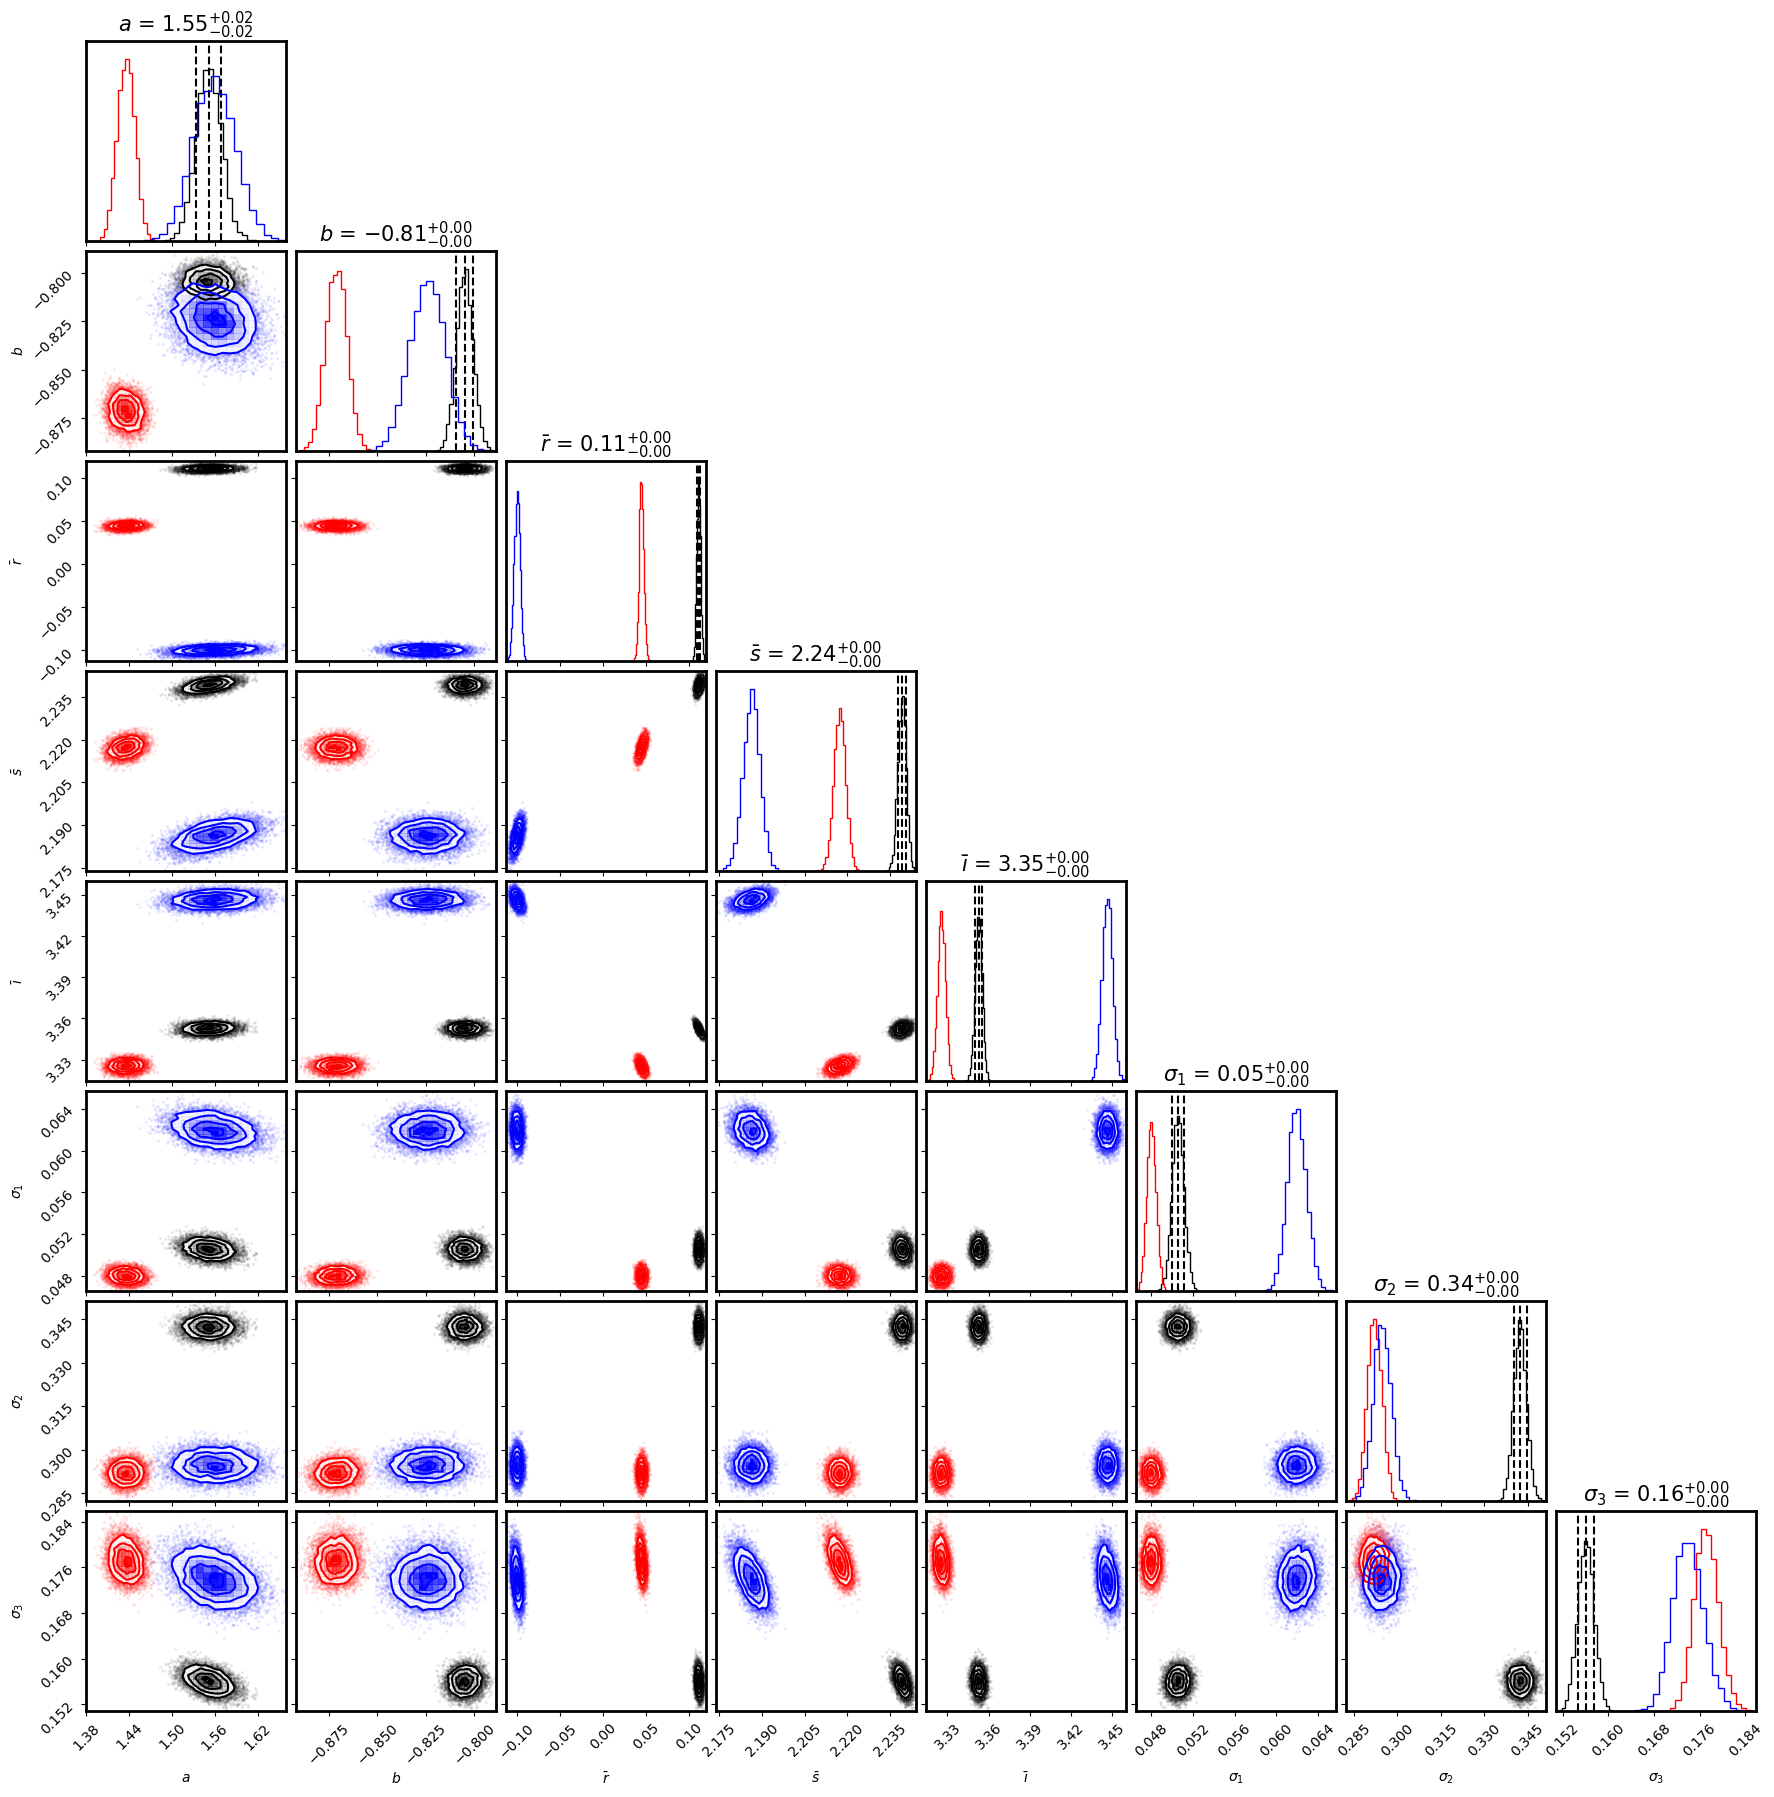

In [56]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

# 1 sigma limit
lim1 = 0.16
lim2 = 1 - lim1

labels = [r'$a$',r'$b$',r'$\bar{r}$',r'$\bar{s}$',r'$\bar{\imath}$',r'$\sigma_1$',r'$\sigma_2$',r'$\sigma_3$']

figure = corner.corner(
    samples_6df, quantiles=[lim1, 0.5, lim2],
show_titles=True, title_kwargs={"fontsize": 15}, labels=labels)

corner.corner(samples_sdss, fig=figure, color='red')
corner.corner(samples_lamost, fig=figure, color='blue')

Removed no burn in
Removed no burn in
Removed no burn in


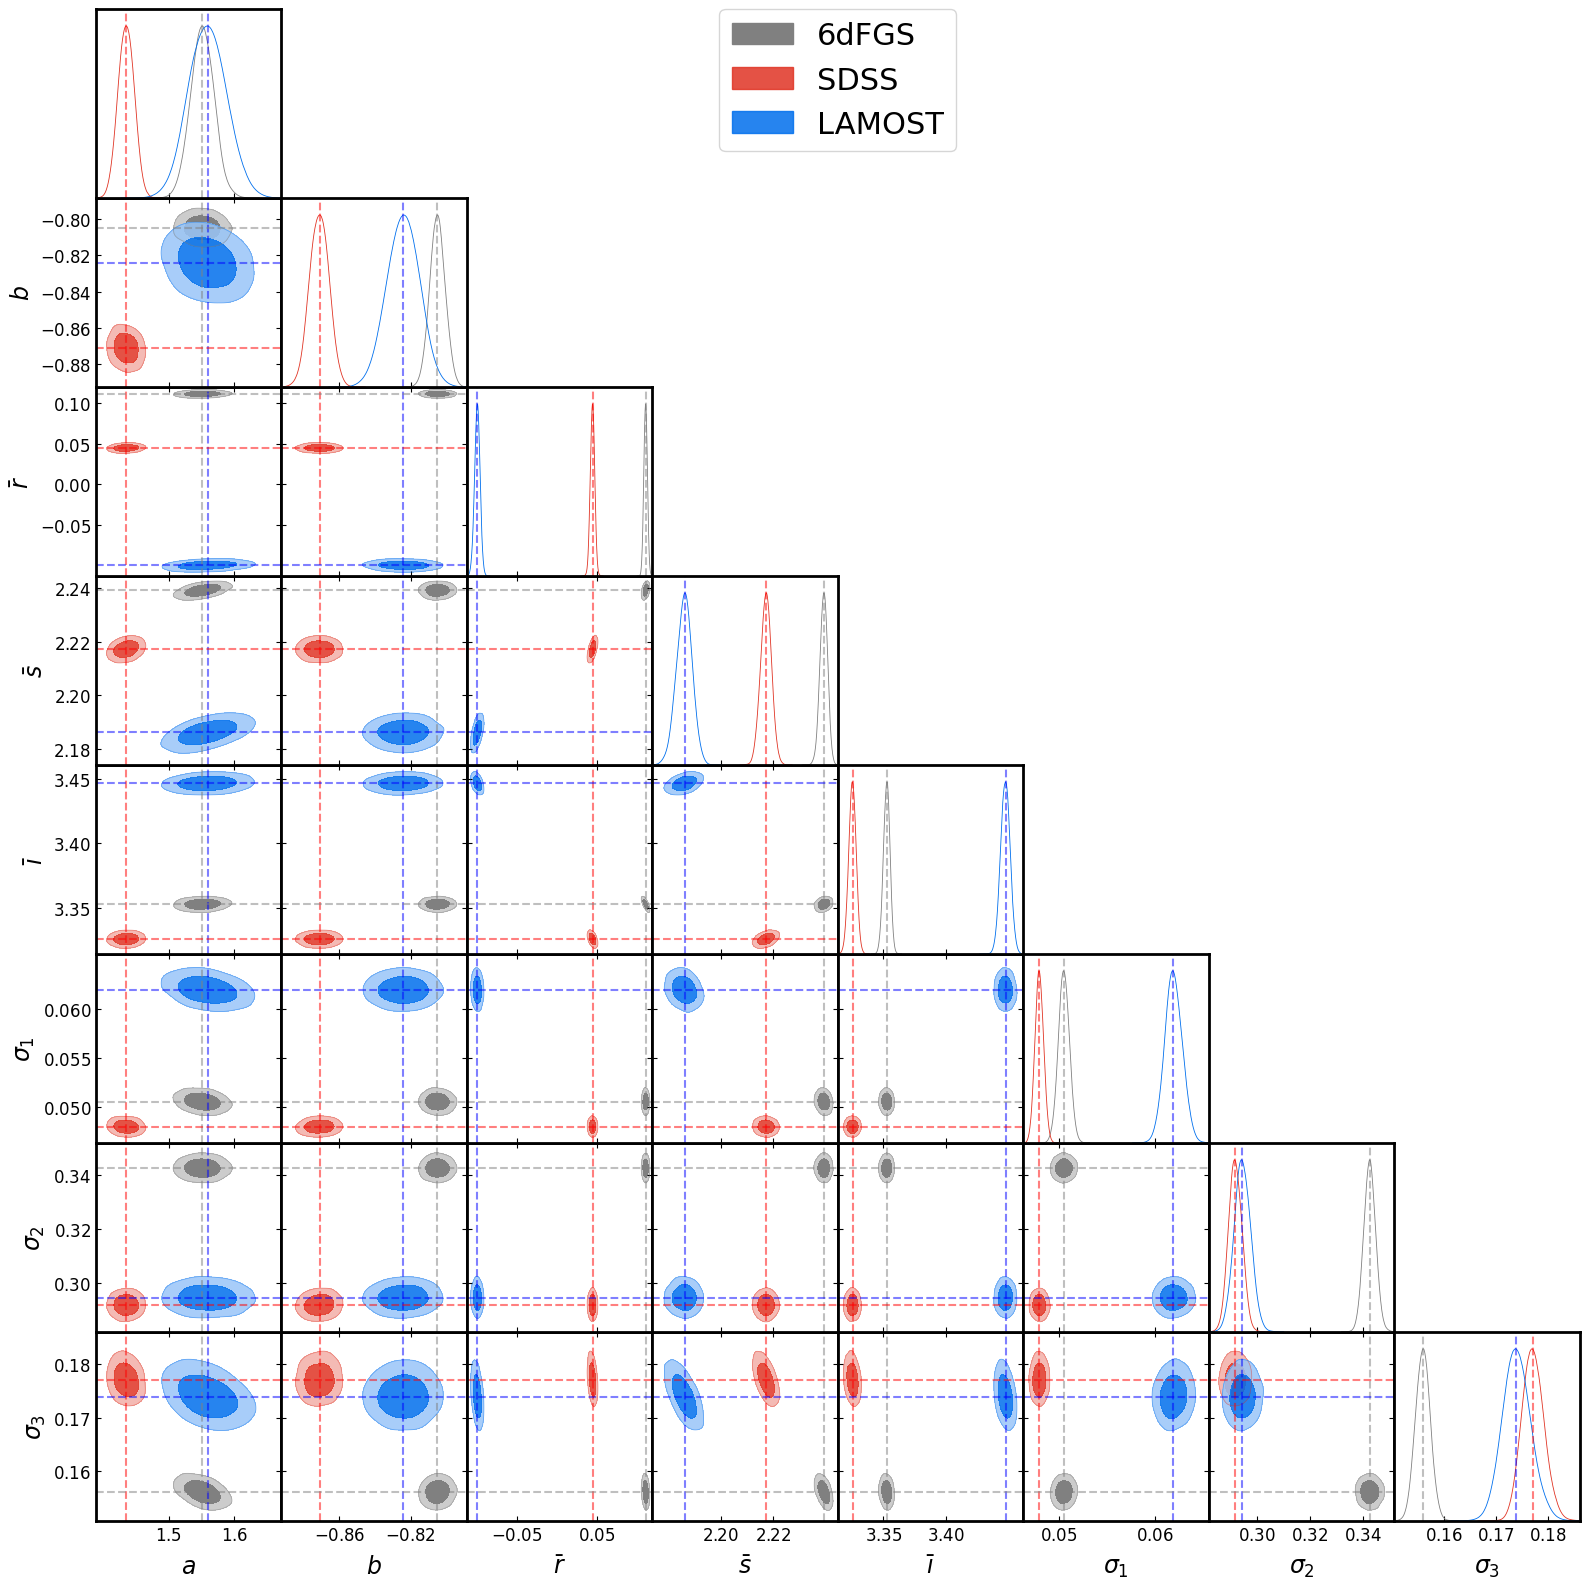

In [57]:
import matplotlib as mpl

# Set border thickness
mpl.rcParams['axes.linewidth'] = 2.0

# 6dFGS data (mocks and previous values)
samples_6df = np.load(MCMC_CHAIN_OUTPUT_FILEPATH['6dFGS'])
prev_vals_6df = pd.read_csv(FP_FIT_FILEPATH, index_col=0).loc['6dFGS'].to_numpy()

# SDSS data (mocks and previous values)
samples_sdss = np.load(MCMC_CHAIN_OUTPUT_FILEPATH['SDSS'])
prev_vals_sdss = pd.read_csv(FP_FIT_FILEPATH, index_col=0).loc['SDSS'].to_numpy()

# LAMOST data (mocks and previous values)
samples_lamost = np.load(MCMC_CHAIN_OUTPUT_FILEPATH['LAMOST'])
prev_vals_lamost = pd.read_csv(FP_FIT_FILEPATH, index_col=0).loc['LAMOST'].to_numpy()

# parameter names
names = [r'$a$', r'$b$', r'$\bar{r}$', r'$\bar{s}$', r'$\bar{\imath}$', r'$\sigma_1$', r'$\sigma_2$', r'$\sigma_3$']

samples1 = MCSamples(samples=samples_6df, names=names, label='6dFGS')
samples2 = MCSamples(samples=samples_sdss, names=names, label='SDSS')
samples3 = MCSamples(samples=samples_lamost, names=names, label='LAMOST')

# Triangle plot
g = plots.get_subplot_plotter()
g.settings.legend_fontsize = 25
g.settings.axes_fontsize = 15
g.settings.axes_labelsize = 20
g.triangle_plot([samples1, samples2, samples3], filled=True)

ndim = 8
for i in range(ndim):    
    for j in range(ndim):
        if j<=i:
            ax = g.subplots[i,j]
            ax.axvline(prev_vals_6df[j], color='grey', ls='--', alpha=0.5)
            ax.axvline(prev_vals_sdss[j], color='red', ls='--', alpha=0.5)
            ax.axvline(prev_vals_lamost[j], color='blue', ls='--', alpha=0.5)
            
            if i != j:
                ax.axhline(prev_vals_6df[i], color='grey', ls='--', alpha=0.5)
                ax.axhline(prev_vals_sdss[i], color='red', ls='--', alpha=0.5)
                ax.axhline(prev_vals_lamost[i], color='blue', ls='--', alpha=0.5)
                
g.export('img/three_surveys_likelihood.png', dpi=300)

# 3. Find the Mean and Std for each parameter

====================a====================
Mean of a = 1.5506
Std of a = 0.0175
====================b====================
Mean of b = -0.8051
Std of b = 0.0044
====================rmean====================
Mean of rmean = 0.1112
Std of rmean = 0.0022
====================smean====================
Mean of smean = 2.2391
Std of smean = 0.0015
====================imean====================
Mean of imean = 3.3528
Std of imean = 0.0026
====================sig1====================
Mean of sig1 = 0.0505
Std of sig1 = 0.0006
====================sig2====================
Mean of sig2 = 0.3424
Std of sig2 = 0.0023
====================sig3====================
Mean of sig3 = 0.1560
Std of sig3 = 0.0014


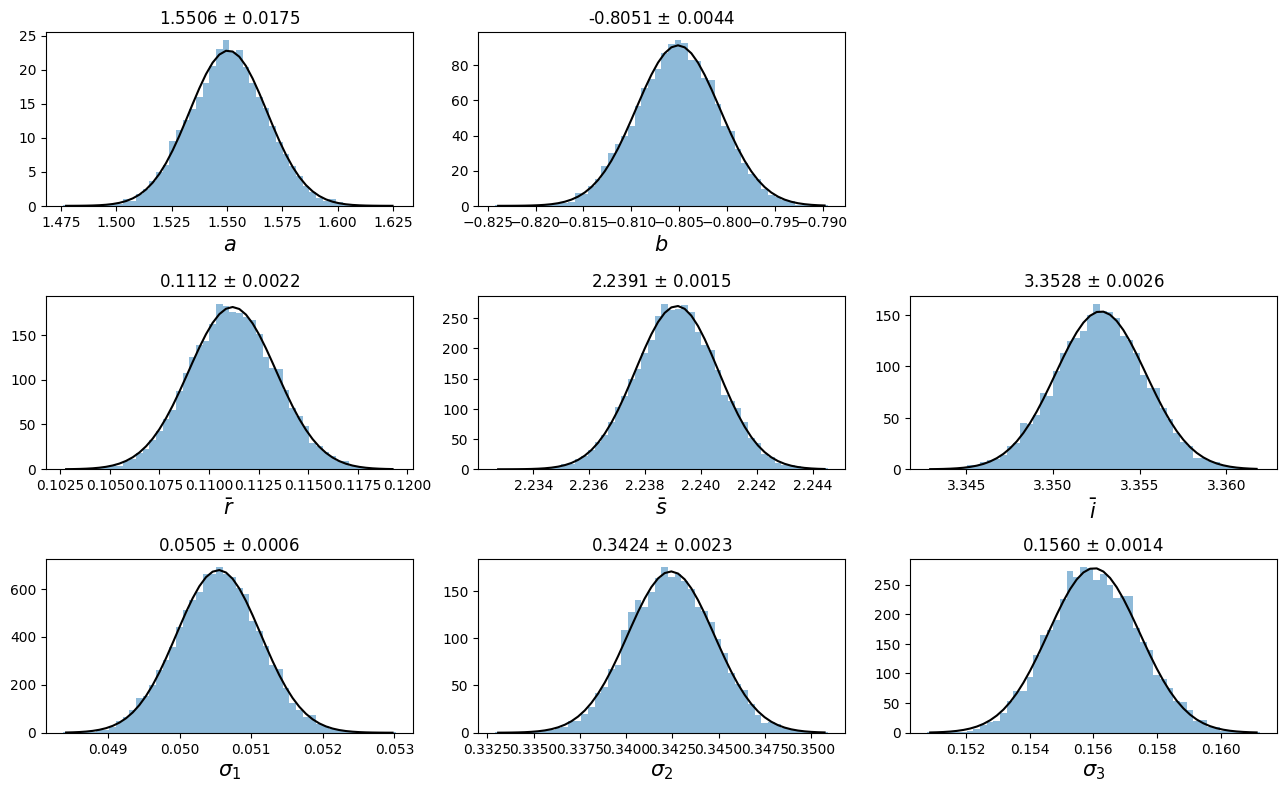

In [121]:
post_dist = np.load('artifacts/fp_fit/6dfgs_chain.npy').T
a = post_dist[0]
b = post_dist[1]
rmean = post_dist[2]
smean = post_dist[3]
imean = post_dist[4]
sigma1 = post_dist[5]
sigma2 = post_dist[6]
sigma3 = post_dist[7]

N = 50

def gaus(x,mu,sig):
    return (1/np.sqrt(2*np.pi*sig**2))*np.exp(-0.5*((x-mu)/sig)**2)

golden_ratio = 1.618
height = 8
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(golden_ratio*height,height))

# a parameter
y, x_edges = np.histogram(a,bins=N,density=True)
x = (x_edges[1:] + x_edges[:-1])/2
popt, pcov = curve_fit(gaus,x,y,p0=[1.4,0.1])
popt = np.absolute(popt)

ax[0,0].hist(a,bins=N,density=True,alpha=0.5)
ax[0,0].plot(x,norm.pdf(x,loc=popt[0],scale=popt[1]),color='black')
ax[0,0].set_xlabel(r'$a$',fontsize=15)
ax[0,0].set_title(r'%.4f' % popt[0] + ' $\pm$ %.4f' % popt[1])
print('='*20 + 'a' + '='*20)
print('Mean of a = %.4f' % popt[0])
print('Std of a = %.4f' % popt[1])

# b parameter
y, x_edges = np.histogram(b,bins=N,density=True)
x = (x_edges[1:] + x_edges[:-1])/2
popt, pcov = curve_fit(gaus,x,y,p0=[-0.8,0.1])
popt[1] = np.absolute(popt[1])

ax[0,1].hist(b,bins=N,density=True,alpha=0.5)
ax[0,1].plot(x,norm.pdf(x,loc=popt[0],scale=popt[1]),color='black')
ax[0,1].set_xlabel(r'$b$',fontsize=15)
# ax[0,1].axvline(x=prev_vals[1],color='red')
# ax[0,1].axvline(x=popt[0],color='black')
ax[0,1].set_title(r'%.4f' % popt[0] + ' $\pm$ %.4f' % popt[1])
print('='*20 + 'b' + '='*20)
print('Mean of b = %.4f' % popt[0])
print('Std of b = %.4f' % popt[1])

# rmean parameter
y, x_edges = np.histogram(rmean,bins=N,density=True)
x = (x_edges[1:] + x_edges[:-1])/2
popt, pcov = curve_fit(gaus,x,y)#,p0=[-0.8,0.1])
popt[1] = np.absolute(popt[1])

ax[1,0].hist(rmean,bins=N,density=True,alpha=0.5)
ax[1,0].plot(x,norm.pdf(x,loc=popt[0],scale=popt[1]),color='black')
ax[1,0].set_xlabel(r'$\bar{r}$',fontsize=15)
# ax[1,0].axvline(x=prev_vals[2],color='red')
# ax[1,0].axvline(x=popt[0],color='black')
ax[1,0].set_title(r'%.4f' % popt[0] + ' $\pm$ %.4f' % popt[1])
print('='*20 + 'rmean' + '='*20)
print('Mean of rmean = %.4f' % popt[0])
print('Std of rmean = %.4f' % popt[1])

# smean parameter
y, x_edges = np.histogram(smean,bins=N,density=True)
x = (x_edges[1:] + x_edges[:-1])/2
popt, pcov = curve_fit(gaus,x,y)#,p0=[-0.8,0.1])
popt[1] = np.absolute(popt[1])

ax[1,1].hist(smean,bins=N,density=True,alpha=0.5)
ax[1,1].plot(x,norm.pdf(x,loc=popt[0],scale=popt[1]),color='black')
ax[1,1].set_xlabel(r'$\bar{s}$',fontsize=15)
# ax[1,1].axvline(x=prev_vals[3],color='red')
# ax[1,1].axvline(x=popt[0],color='black')
ax[1,1].set_title(r'%.4f' % popt[0] + ' $\pm$ %.4f' % popt[1])
print('='*20 + 'smean' + '='*20)
print('Mean of smean = %.4f' % popt[0])
print('Std of smean = %.4f' % popt[1])

# imean parameter
y, x_edges = np.histogram(imean,bins=N,density=True)
x = (x_edges[1:] + x_edges[:-1])/2
popt, pcov = curve_fit(gaus,x,y)#,p0=[-0.8,0.1])
popt[1] = np.absolute(popt[1])

ax[1,2].hist(imean,bins=N,density=True,alpha=0.5)
ax[1,2].plot(x,norm.pdf(x,loc=popt[0],scale=popt[1]),color='black')
ax[1,2].set_xlabel(r'$\bar{i}$',fontsize=15)
# ax[1,2].axvline(x=prev_vals[4],color='red')
# ax[1,2].axvline(x=popt[0],color='black')
ax[1,2].set_title(r'%.4f' % popt[0] + ' $\pm$ %.4f' % popt[1])
print('='*20 + 'imean' + '='*20)
print('Mean of imean = %.4f' % popt[0])
print('Std of imean = %.4f' % popt[1])

# sigma1 parameter
y, x_edges = np.histogram(sigma1,bins=N,density=True)
x = (x_edges[1:] + x_edges[:-1])/2
popt, pcov = curve_fit(gaus,x,y)#,p0=[-0.8,0.1])
popt[1] = np.absolute(popt[1])

ax[2,0].hist(sigma1,bins=N,density=True,alpha=0.5)
ax[2,0].plot(x,norm.pdf(x,loc=popt[0],scale=popt[1]),color='black')
ax[2,0].set_xlabel(r'$\sigma_1$',fontsize=15)
# ax[2,0].axvline(x=prev_vals[5],color='red')
# ax[2,0].axvline(x=popt[0],color='black')
ax[2,0].set_title(r'%.4f' % popt[0] + ' $\pm$ %.4f' % popt[1])
print('='*20 + 'sig1' + '='*20)
print('Mean of sig1 = %.4f' % popt[0])
print('Std of sig1 = %.4f' % popt[1])

# sigma2 parameter
y, x_edges = np.histogram(sigma2,bins=N,density=True)
x = (x_edges[1:] + x_edges[:-1])/2
popt, pcov = curve_fit(gaus,x,y)#,p0=[-0.8,0.1])
popt[1] = np.absolute(popt[1])

ax[2,1].hist(sigma2,bins=N,density=True,alpha=0.5)
ax[2,1].plot(x,norm.pdf(x,loc=popt[0],scale=popt[1]),color='black')
ax[2,1].set_xlabel(r'$\sigma_2$',fontsize=15)
# ax[2,1].axvline(x=prev_vals[6],color='red')
# ax[2,1].axvline(x=popt[0],color='black')
ax[2,1].set_title(r'%.4f' % popt[0] + ' $\pm$ %.4f' % popt[1])
print('='*20 + 'sig2' + '='*20)
print('Mean of sig2 = %.4f' % popt[0])
print('Std of sig2 = %.4f' % popt[1])

# sigma3 parameter
y, x_edges = np.histogram(sigma3,bins=N,density=True)
x = (x_edges[1:] + x_edges[:-1])/2
popt, pcov = curve_fit(gaus,x,y)#,p0=[-0.8,0.1])
popt[1] = np.absolute(popt[1])

ax[2,2].hist(sigma3,bins=N,density=True,alpha=0.5)
ax[2,2].plot(x,norm.pdf(x,loc=popt[0],scale=popt[1]),color='black')
ax[2,2].set_xlabel(r'$\sigma_3$',fontsize=15)
# ax[2,2].axvline(x=prev_vals[7],color='red')
# ax[2,2].axvline(x=popt[0],color='black')
ax[2,2].set_title(r'%.4f' % popt[0] + ' $\pm$ %.4f' % popt[1])
print('='*20 + 'sig3' + '='*20)
print('Mean of sig3 = %.4f' % popt[0])
print('Std of sig3 = %.4f' % popt[1])

fig.delaxes(ax[0,2])
fig.tight_layout(pad=1.0)
# plt.savefig('FPparams_LAMOST.png',dpi=400)
plt.show()

Fitting the FP likelihood of 6dFGS
====================a====================
Mean of a = 1.5506
Std of a = 0.0175
====================b====================
Mean of b = -0.8051
Std of b = 0.0044
====================rmean====================
Mean of rmean = 0.1112
Std of rmean = 0.0022
====================smean====================
Mean of smean = 2.2391
Std of smean = 0.0015
====================imean====================
Mean of imean = 3.3528
Std of imean = 0.0026
====================sigma1====================
Mean of sigma1 = 0.0505
Std of sigma1 = 0.0006
====================sigma2====================
Mean of sigma2 = 0.3424
Std of sigma2 = 0.0023
====================sigma3====================
Mean of sigma3 = 0.1560
Std of sigma3 = 0.0014


Fitting the FP likelihood of SDSS
====================a====================
Mean of a = 1.4348
Std of a = 0.0123
====================b====================
Mean of b = -0.8708
Std of b = 0.0054
====================rmean====================
Mean of rm

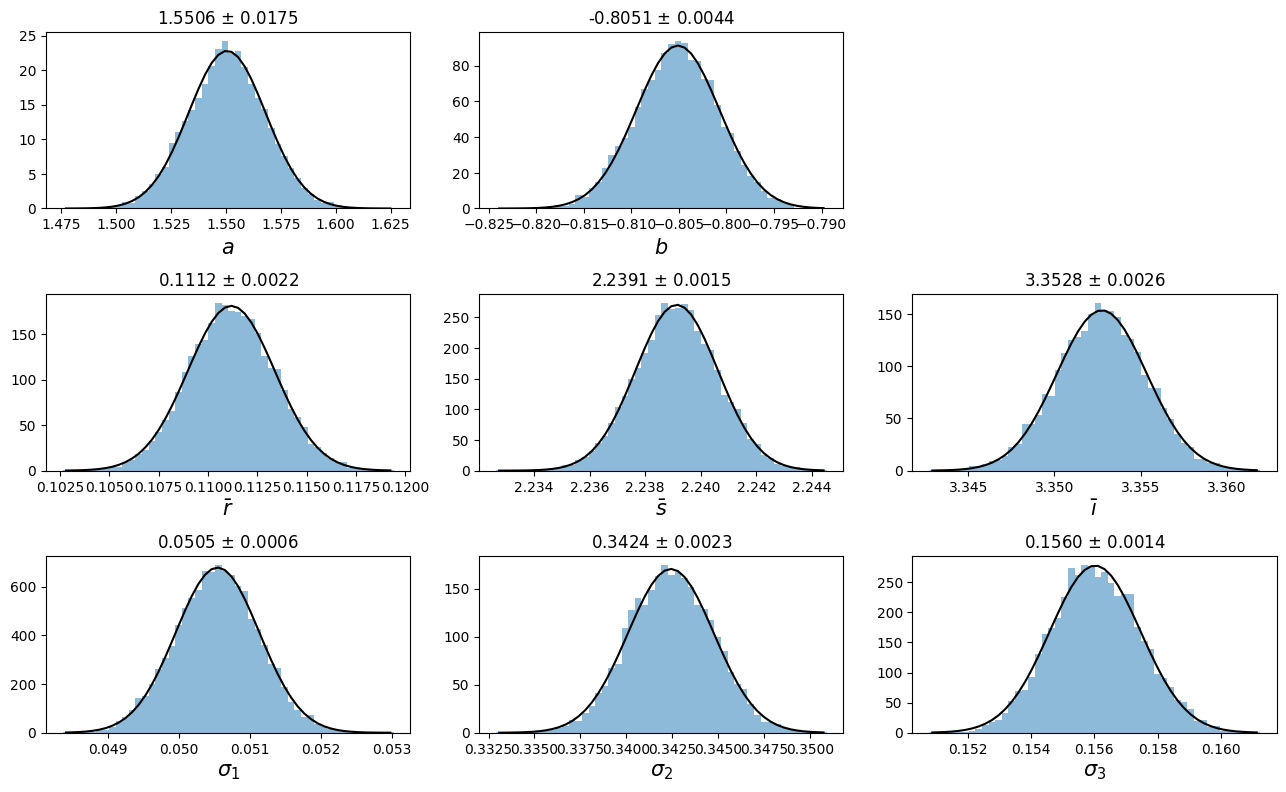

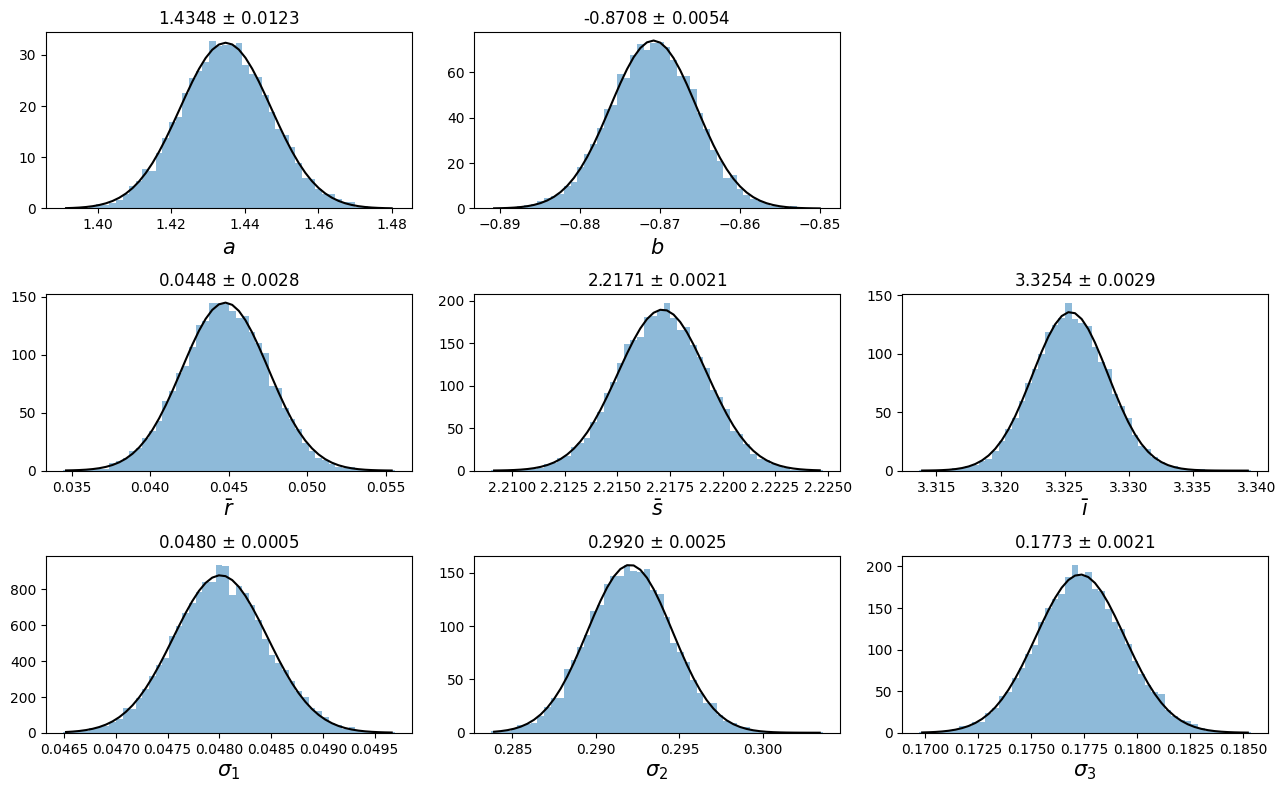

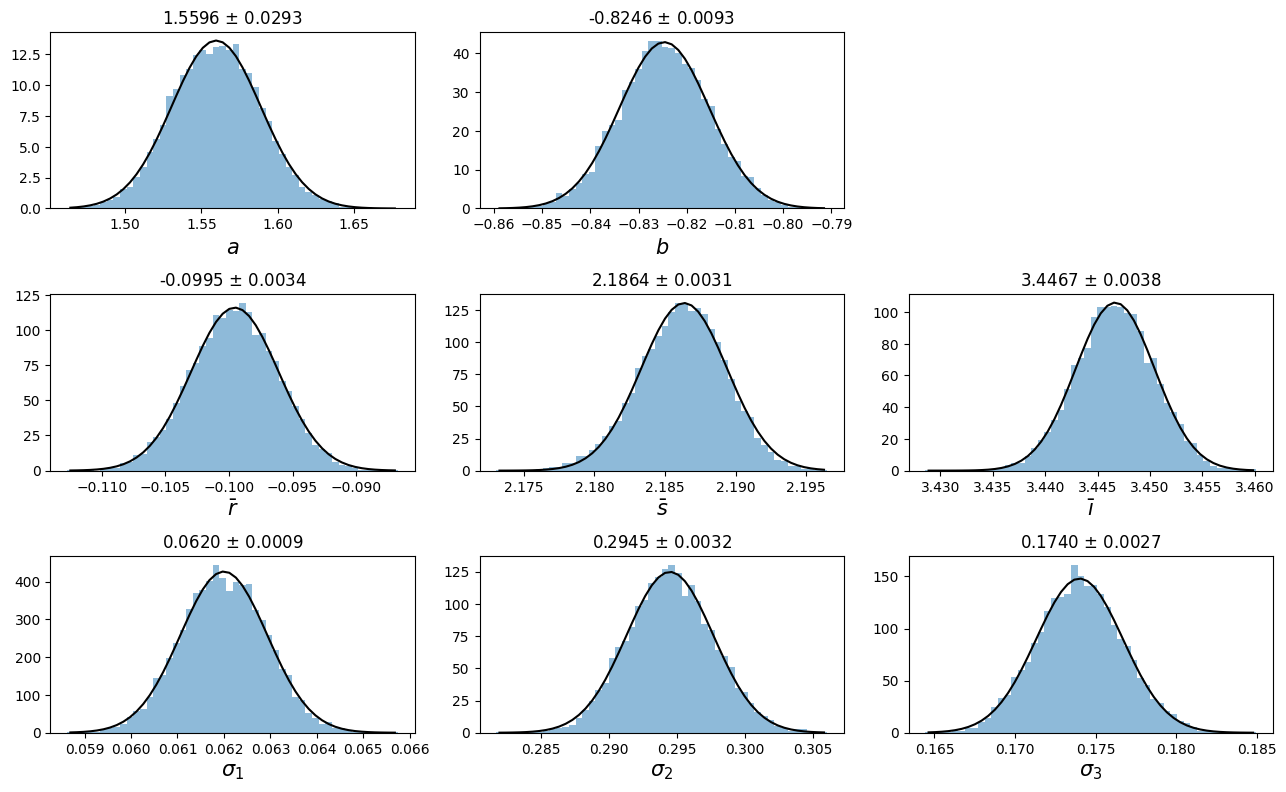

In [151]:
def fit_likelihood():
    
    def fit_and_plot(posteriors, fp_paramname, fp_labelname, axis):
        def gaus(x, mu, sig):
            return (1 / np.sqrt(2 * np.pi * sig**2)) * np.exp(-0.5 * ((x - mu) / sig)**2)
        
        xdata = posteriors[fp_paramname]
        y, x_edges = np.histogram(xdata, bins=N, density=True)
        x = (x_edges[1:] + x_edges[:-1])/2
        popt, pcov = curve_fit(gaus, x, y, p0=[np.mean(xdata), np.std(xdata)])
        popt[1] = np.absolute(popt[1])
        
        axis.hist(xdata, bins=N, density=True, alpha=0.5)
        axis.plot(x, norm.pdf(x, loc=popt[0], scale=popt[1]), color='black')
        axis.set_xlabel(fp_labelname, fontsize=15)
        axis.set_title(r'%.4f' % popt[0] + ' $\pm$ %.4f' % popt[1])
        print('='*20 + fp_paramname + '='*20)
        print(f'Mean of {fp_paramname} = %.4f' % popt[0])
        print(f'Std of {fp_paramname} = %.4f' % popt[1])
        fig.tight_layout(pad=1.0)
    
    N = 50
    for survey in SURVEY_LIST:
        print(f"Fitting the FP likelihood of {survey}")
        post_dist = np.load(MCMC_CHAIN_OUTPUT_FILEPATH[survey]).T
        posteriors = {
            'a': post_dist[0],
            'b': post_dist[1],
            'rmean': post_dist[2],
            'smean': post_dist[3],
            'imean': post_dist[4],
            'sigma1': post_dist[5],
            'sigma2': post_dist[6],
            'sigma3': post_dist[7]
        }
        
        fp_paramname_list = ['a', 'b', 'rmean', 'smean', 'imean', 'sigma1', 'sigma2', 'sigma3']
        fp_labelname_list = [r'$a$', r'$b$', r'$\bar{r}$', r'$\bar{s}$', r'$\bar{\imath}$', r'$\sigma_1$', r'$\sigma_2$', r'$\sigma_3$']
        
        golden_ratio = 1.618
        height = 8
        
        fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(golden_ratio * height, height))
        fig.delaxes(fig.axes[2])
        
        for idx, ax in enumerate(fig.axes):
            fit_and_plot(posteriors, fp_paramname_list[idx], fp_labelname_list[idx], ax)
        print('\n')
        
fit_likelihood()

In [122]:
for survey in SURVEY_LIST[:1]:
    print(survey)

6dFGS


# 3. Fit the log-distance ratio

In [130]:
# package to find mode from local maxima
from scipy.signal import find_peaks

LOGDIST_FILEPATH = {
    '6dFGS': 'data/foundation/logdist/6dfgs.csv',
    'SDSS': 'data/foundation/logdist/sdss.csv',
    'LAMOST': 'data/foundation/logdist/lamost.csv'
}

if __name__ == "__main__":
    # Load the file
    for survey in ['6dFGS']:
        data = pd.read_csv(OUTLIER_REJECT_OUTPUT_FILEPATH[survey])
        FP_params = pd.read_csv(FP_FIT_FILEPATH, index_col=0).loc[survey].to_numpy()

        # The magnitude limit and velocity dispersion limits (very important!), and Omega_m (less important)
        omega_m = 0.3121
        smin = np.log10(112)
        mag_low = 8.0
        mag_high = 13.65

        # Get some redshift-distance lookup tables
        red_spline, lumred_spline, dist_spline, lumdist_spline, ez_spline = rz_table()
        # The comoving distance to each galaxy using group redshift as distance indicator
        dz = sp.interpolate.splev(data["z_dist_est"].to_numpy(), dist_spline, der=0) 

        # Compute the PDF of log-distance ratios for each galaxy
        # Minimum and maximum candidate log-distance ratio
        dmin, dmax, nd = -1.5, 1.5, 1001
        dbins = np.linspace(dmin, dmax, nd, endpoint=True)

        # Determine all possible true distances and the corresponding true redshift
        d_H = np.outer(10.0**(-dbins), dz)
        z_H = sp.interpolate.splev(d_H, red_spline, der=0)
        # The integration limit for the fn term (evolution correction is ignored)
        lmin = (SOLAR_MAGNITUDE['j'] + 5.0*np.log10(1.0+data["zhelio"].to_numpy()) + data["kcor_j"].to_numpy() + data["extinction_j"].to_numpy() + 10.0 - 2.5*np.log10(2.0*np.pi) + 5.0*np.log10(d_H) - mag_high)/5.0   # These are the minimum and maximum values of the f_n integral - complicated, so will need to read the Appendix of the SDSS paper.
        lmax = (SOLAR_MAGNITUDE['j'] + 5.0*np.log10(1.0+data["zhelio"].to_numpy()) + data["kcor_j"].to_numpy() + data["extinction_j"].to_numpy() + 10.0 - 2.5*np.log10(2.0*np.pi) + 5.0*np.log10(d_H) - mag_low)/5.0    # The only parts that will need changing are the Sun's magnitude (here it's 4.65 for r-band), and evolution correction (here it's -0.85*z)

        # Compute the log likelihood of the log-distance ratio
        # Using the best-fit FP parameters found above
        loglike = FP_func(FP_params, dbins, data["z_cmb"].to_numpy(), data["r"].to_numpy(), data["s"].to_numpy(), data["i"].to_numpy(), data["er"].to_numpy(), data["es"].to_numpy(), data["ei"].to_numpy(), np.ones(len(data)), dz, data["kcor_j"].to_numpy(), data["extinction_j"].to_numpy(), smin, sumgals=False)
        FNvals = FN_func(FP_params, data["z_cmb"].to_numpy(), data["er"].to_numpy(), data["es"].to_numpy(), data["ei"].to_numpy(), lmin, lmax, smin)
            
        logP_dist = -1.5 * np.log(2.0 * np.pi) - loglike - FNvals

        # Normalize the likelihood distribution
        ddiff = np.log10(d_H[:-1]) - np.log10(d_H[1:])
        valdiff = np.exp(logP_dist[1:]) + np.exp(logP_dist[0:-1])
        norm_ = 0.5 * np.sum(valdiff * ddiff, axis=0)

        logP_dist -= np.log(norm_[:, None]).T

        # Calculate the mean and variance of the gaussian
        mean = np.sum(dbins[0:-1,None]*np.exp(logP_dist[0:-1])+dbins[1:,None]*np.exp(logP_dist[1:]), axis=0)*(dbins[1]-dbins[0])/2.0
        err = np.sqrt(np.sum(dbins[0:-1,None]**2*np.exp(logP_dist[0:-1])+dbins[1:,None]**2*np.exp(logP_dist[1:]), axis=0)*(dbins[1]-dbins[0])/2.0 - mean**2)

        # My addition to Cullan's code to handle several peaks occurring
        # Locate the rightmost local maximum (called the mode here)
        peak_list = []
        peak_index = []
        mode = []

        y = np.exp(logP_dist.T)

        for i in range(np.size(y,0)):
            peaks, _ = find_peaks(y[i,:])
            peak_index.append(peaks)
            peak_list.append(dbins[peaks])

        for idx in peak_index:
            if len(idx) > 1:
                mode.append(dbins[idx[-1]])
            else:
                mode.append(dbins[idx][0])

        # Logdistance ratio: use the mode if double peaked, mean if single peaked
        eta = []
        for i in range(len(peak_index)):
            if len(peak_index[i])>1:
                eta.append(mode[i])
            else:
                eta.append(mean[i])

        # Store everything
        data["mean"] = mean
        data["mode"] = mode
        data["mean_minus_mode"] = mean - mode
        data["eta"] = eta
        data["eta_err"] = err

        # Save the data
        data.to_csv(LOGDIST_FILEPATH[survey], index=False)

In [92]:
y

array([[2.84963919e-20, 3.88178838e-20, 5.28461013e-20, ...,
        7.40665657e-29, 5.87407119e-29, 4.65782533e-29],
       [5.47191639e-21, 7.63735049e-21, 1.06524579e-20, ...,
        2.00764066e-35, 1.53564701e-35, 1.17440978e-35],
       [7.51333215e-26, 1.07417542e-25, 1.53468621e-25, ...,
        5.42729201e-31, 4.22611063e-31, 3.29016692e-31],
       ...,
       [7.77054019e-11, 9.98567817e-11, 1.28252600e-10, ...,
        6.95052588e-32, 5.58161521e-32, 4.48181871e-32],
       [5.27487743e-17, 7.16804078e-17, 9.73433159e-17, ...,
        1.34502197e-35, 1.04139423e-35, 8.06187133e-36],
       [1.81797493e-25, 2.52588458e-25, 3.50739260e-25, ...,
        6.21480439e-22, 5.13726128e-22, 4.24592401e-22]])

In [86]:
data['mean_minus_mode'].sort_values()

6033   -0.052315
5253   -0.051463
8712   -0.049431
1190   -0.048054
4379   -0.047350
          ...   
1277    0.006565
5581    0.007006
2667    0.007086
6908    0.007308
6115    0.008495
Name: mean_minus_mode, Length: 8736, dtype: float64

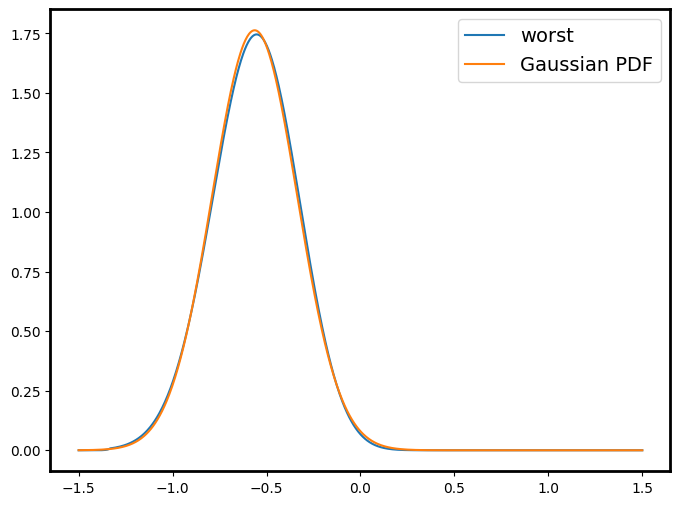

In [131]:
post_index = 4566
plt.figure(figsize=(8, 6))
plt.plot(dbins, y[post_index, :], label='worst')
plt.plot(dbins, norm.pdf(dbins, mean[post_index], err[post_index]), label='Gaussian PDF')

plt.legend(fontsize=14)

## Inspect the logdists

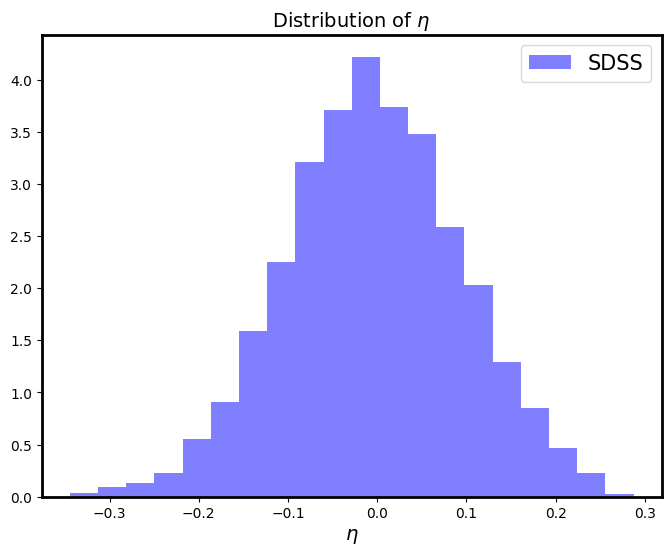

In [144]:
df_6df = pd.read_csv('data/foundation/logdist/6dfgs.csv')
df_sdss = pd.read_csv('data/foundation/logdist/sdss.csv')
df_lamost = pd.read_csv('data/foundation/logdist/lamost.csv')

plt.figure(figsize=(8, 6))
# plt.hist(df_6df[df_6df['z_cmb'] * LIGHTSPEED > 3000]['eta'], density=True, bins=20, alpha=0.5, label='6dFGS before', color='red')
# plt.hist(df_6df[df_6df['z_cmb'] * LIGHTSPEED > 10000]['eta'], density=True, bins=20, alpha=0.5, label='6dFGS after', color='blue')

plt.hist(df_sdss['eta'], density=True, bins=20, alpha=0.5, label='SDSS', color='blue')
# plt.hist(df_lamost['eta'], density=True, bins=20, alpha=0.5, label='LAMOST', color='green')

plt.xlabel(r'$\eta$', fontsize=14)
plt.title(r'Distribution of $\eta$', fontsize=14)


plt.legend(fontsize=15)
plt.show()

In [132]:
df_6df

,tmass,_6dFGS,ra,dec,zhelio,z_cmb,z_dist_est,j_m_ext,extinction_j,kcor_j,...,er,s,es,i,ei,mean,mode,mean_minus_mode,eta,eta_err
0,2MASXJ00001440-7652248,g0000144-765225,0.05985,-76.87364,0.0533,0.053168,0.053168,13.177,0.044354,-0.034565,...,0.039298,2.161174,0.073056,3.133843,0.078596,0.092306,0.105,-0.012694,0.092306,0.141491
1,2MASXJ00002213-0137463,g0000222-013746,0.09225,-1.62947,0.0383,0.037063,0.037063,12.625,0.025941,-0.024528,...,0.034122,2.363345,0.022904,3.991557,0.068244,0.072517,0.078,-0.005483,0.072517,0.105710
2,2MASXJ00002348-0656103,g0000235-065610,0.09780,-6.93619,0.0376,0.036387,0.036387,12.595,0.025629,-0.023863,...,0.033834,2.244536,0.045042,3.350527,0.067668,0.052571,0.060,-0.007429,0.052571,0.116209
3,2MASXJ00002509-2602401,g0000251-260240,0.10455,-26.04450,0.0508,0.049740,0.049740,12.495,0.011846,-0.030792,...,0.032997,2.398988,0.039951,3.826051,0.065995,0.151201,0.156,-0.004799,0.151201,0.114985
4,2MASXJ00003564-0145472,g0000356-014547,0.14850,-1.76317,0.0244,0.023181,0.023181,12.242,0.026393,-0.019529,...,0.030402,2.165143,0.066088,2.943404,0.060804,-0.088457,-0.081,-0.007457,-0.088457,0.124759
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8731,2MASXJ23585980-5527301,g2358598-552730,359.74905,-55.45833,0.0111,0.010538,0.010538,9.217,0.007586,-0.008959,...,0.016548,2.429375,0.014993,3.302255,0.033097,-0.021327,-0.021,-0.000327,-0.021327,0.103976
8732,2MASXJ23585991-6200483,g2358599-620048,359.74965,-62.01342,0.0303,0.029857,0.029857,12.242,0.012499,-0.021229,...,0.030537,2.158557,0.028084,3.188233,0.061074,0.104293,0.108,-0.003707,0.104293,0.103378
8733,2MASXJ23590350-0524185,g2359035-052419,359.76450,-5.40517,0.0306,0.029386,0.029386,12.556,0.022767,-0.020547,...,0.033483,2.196381,0.069937,3.461368,0.066966,0.033899,0.042,-0.008101,0.033899,0.125094
8734,2MASXJ23591929-3143478,g2359193-314348,359.83050,-31.72992,0.0280,0.027034,0.027034,12.172,0.011255,-0.021255,...,0.029870,2.320115,0.032015,3.350873,0.059740,-0.074866,-0.069,-0.005866,-0.074866,0.109877


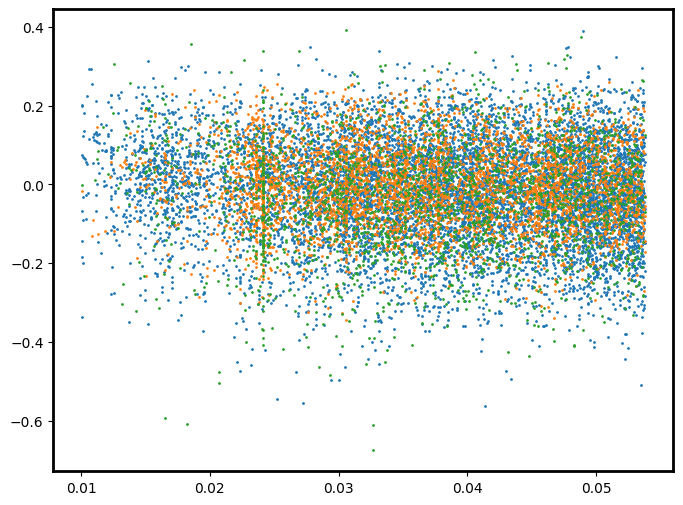

In [110]:
plt.figure(figsize=(8, 6))
plt.scatter(df_6df['z_dist_est'], df_6df['eta'], label='6dFGS', s=1)
plt.scatter(df_sdss['z_dist_est'], df_sdss['eta'], label='SDSS', s=1)
plt.scatter(df_lamost['z_dist_est'], df_lamost['eta'], label='LAMOST', s=1)

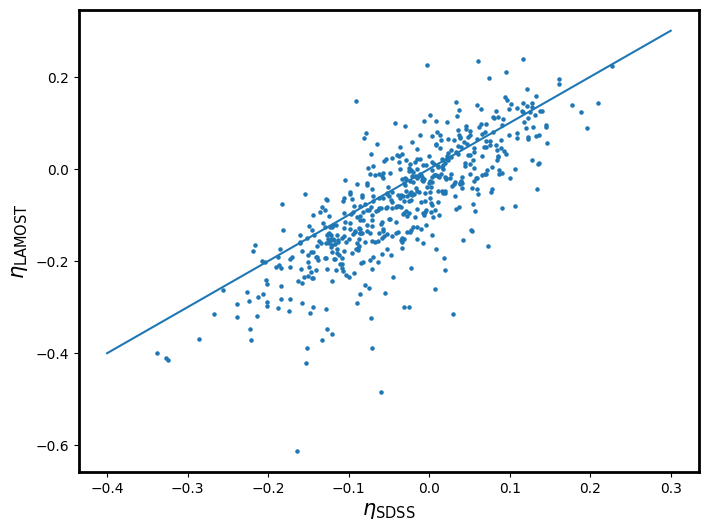

In [127]:
df_sl = df_sdss.merge(df_lamost, on='tmass', how='inner')

plt.figure(figsize=(8, 6))
# plt.errorbar(x=df_sl['eta_x'], y=df_sl['eta_y'], xerr=df_sl['eta_err_x'], yerr=df_sl['eta_err_y'], fmt='.', elinewidth=0.5)
plt.scatter(x=df_sl['eta_x'], y=df_sl['eta_y'], s=5)
plt.plot([-0.4, 0.3], [-0.4, 0.3])
plt.xlabel(r'$\eta_\mathrm{SDSS}$', fontsize=15)
plt.ylabel(r'$\eta_\mathrm{LAMOST}$', fontsize=15)

plt.show()